<a href="https://colab.research.google.com/github/x1ew/Multi-class-Weather/blob/main/Multi_Class_Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***import Data***


In [ ]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torch.nn.functional as F 


from glob import glob
import re
from PIL import Image
import random

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
!gdown '1IePL_iR5TPejZ1Vf7P51NoaoNlmjCciI'
!unzip "Multi-class Weather Dataset.zip"

Downloading...
From: https://drive.google.com/uc?id=1IePL_iR5TPejZ1Vf7P51NoaoNlmjCciI
To: /content/Multi-class Weather Dataset.zip
100% 95.7M/95.7M [00:00<00:00, 99.1MB/s]
Archive:  Multi-class Weather Dataset.zip
   creating: Multi-class Weather Dataset/
   creating: Multi-class Weather Dataset/Cloudy/
  inflating: Multi-class Weather Dataset/Cloudy/cloudy1.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy10.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy100.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy101.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy102.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy103.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy104.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy105.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy106.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy107.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy108.

#***Dataset and Dataloader*** 

In [ ]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           size,
                           valid_size=0.2):

    # define transforms
    valid_transform = transforms.Compose([transforms.Resize([size,size]),
                                        #   transforms.Grayscale(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])
    if augment:
        train_transform = transforms.Compose([transforms.Resize([size,size]),
                                              transforms.RandomHorizontalFlip(p=0.5),
                                              transforms.RandomRotation(degrees=(-90, 90)),
                                              transforms.RandomVerticalFlip(p=0.5),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])
    else:
        train_transform = transforms.Compose([transforms.Resize([size,size]),
                                            #   transforms.Grayscale(),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])

    # load the dataset
    train_dataset = ImageFolder(
        root=data_dir, transform=train_transform,
    )

    valid_dataset = ImageFolder(
        root=data_dir, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)


    return (train_loader, valid_loader)

In [ ]:
trainloader, testloader = get_train_valid_loader("./Multi-class Weather Dataset/", batch_size=32, augment=False, size=250, valid_size=0.2)

#***Analyse Data***

In [ ]:
trainloader.dataset

Dataset ImageFolder
    Number of datapoints: 1125
    Root location: ./Multi-class Weather Dataset/
    StandardTransform
Transform: Compose(
               Resize(size=[250, 250], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
testloader.dataset

Dataset ImageFolder
    Number of datapoints: 1125
    Root location: ./Multi-class Weather Dataset/
    StandardTransform
Transform: Compose(
               Resize(size=[250, 250], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Create a dataframe containing each image's path and class

In [ ]:
file_paths = glob("./Multi-class Weather Dataset/*/*")
labels = list()
for path in file_paths:
    file_name = path[path.rfind("/")+1:]
    labels.append(file_name[:re.search(r"\d", file_name).start()])
df = pd.DataFrame({'path': file_paths, 'class': labels})

How many classes our dataset have?

In [ ]:
classes = df['class'].unique()
classes

array(['rain', 'cloudy', 'sunrise', 'shine'], dtype=object)

How much of each class do we have?

[('rain', 215), ('cloudy', 300), ('sunrise', 357), ('shine', 253)]


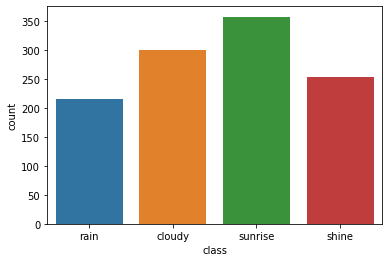

In [ ]:
lenclasses = [(i, len(df[df['class'] == i])) for i in classes]
print(lenclasses)
ax = sns.countplot(data=df, x="class")

See some of the images

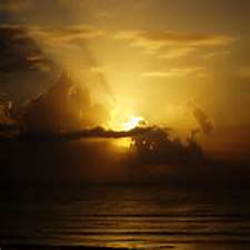

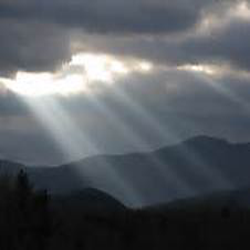

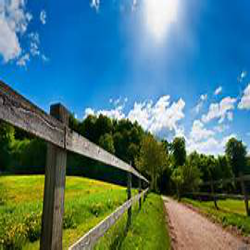

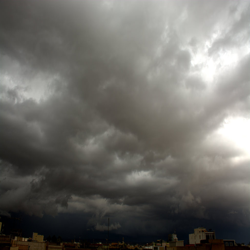

In [ ]:
for i in range(4):
    img = Image.open(df.path[random.randint(0, len(df))]).convert('RGB').resize((250,250))
    display(img)

What is the size of original images?

In [ ]:
img = Image.open(df.path[0])
img.size

(852, 480)

#***Utility functions***

In [ ]:
def train(model, trainloader, criterion, optimizer, n):
    corrects = 0 
    losses = []
    model.train()
    for X, y in trainloader:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        
        _, predict = torch.max(output, dim = 1)
        corrects += torch.sum(predict == y)

        loss = criterion(output, y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step() #update weight
        optimizer.zero_grad()
        
    return (corrects.item() / n), np.mean(losses)

In [ ]:
def validation(model, testloader, criterion, n):
    losses = []
    corrects = 0
    model.eval()
    with torch.no_grad():
        for X, y in testloader:
            X = X.to(device)
            y = y.to(device)

            outputs = model(X)
            _, pred = torch.max(outputs, dim=1)
            corrects += torch.sum(pred == y)

            loss = criterion(outputs, y)
            losses.append(loss.item())
        
    return (corrects.item() / n), np.mean(losses)

In [ ]:
def fit(model, criterion, optimizer, EPOCHS):
    losses_train, losses_valid, acc_train, acc_valid, predicts = ([] for i in range(5))
    best_acc = 0

    for e in range(EPOCHS):
        train_c, train_l = train(model, trainloader, criterion, optimizer, len(trainloader.sampler))
        print(f"Epoch {e + 1} --- train accuracy {train_c * 100:.3f}    train losses {train_l:.3f}", end='')
        losses_train.append(train_l)  
        acc_train.append(train_c)  

        val_c, val_l = validation(model, testloader, criterion, len(testloader.sampler))
        print(f" --- valid accuracy {val_c * 100:.3f}   valid losses {val_l:.3f}")
        losses_valid.append(val_l)
        acc_valid.append(val_c)
    return losses_train, losses_valid, acc_train, acc_valid

In [ ]:
globprec, globrec, globf1 = 0, 0, 0

def show_metrics(model, dataloader, filename=None):
    global globprec, globrec, globf1
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X, y in dataloader:
            outputs = model(X.to(device))
            _, pred = torch.max(outputs, dim=1)
            y_pred.append(pred)
            y_true.append(y)
    y_pred = torch.cat(y_pred).cpu()
    y_true = torch.cat(y_true)
    creport = classification_report(y_true, y_pred)
    print(creport)
    globprec, globrec, globf1, _ = precision_recall_fscore_support(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    disp.plot()
    if filename:
        plt.savefig(filename)

In [ ]:
def plotplz(filename=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    # ax1.title("Training and Validation Accuracy")
    ax1.plot(acc_valid,label="val")
    ax1.plot(acc_train,label="train")
    ax1.set_xlabel("iterations")
    ax1.set_ylabel("accuracy")
    ax1.legend()

    ax2.plot(losses_valid,label="val")
    ax2.plot(losses_train,label="train")
    ax2.set_xlabel("iterations")
    ax2.set_ylabel("loss")
    ax2.legend()
    if filename:
        fig.savefig(filename)


#***Fully Connected Models***

##***2-layer***

### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(250 * 250 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1               [-1, 187500]               0
            Linear-2                  [-1, 512]      96,000,512
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 4]           1,028
           Softmax-7                    [-1, 4]               0
Total params: 96,132,868
Trainable params: 96,132,868
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.72
Forward/backward pass size (MB): 1.44
Params size (MB): 366.72
Estimated Total Size (MB): 368.88
----------------------------------------------------------------


In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 52.667    train losses 1.324--- valid accuracy 52.000   valid losses 1.331
Epoch 2 --- train accuracy 59.333    train losses 1.310--- valid accuracy 63.556   valid losses 1.325
Epoch 3 --- train accuracy 58.444    train losses 1.313--- valid accuracy 56.444   valid losses 1.336
Epoch 4 --- train accuracy 63.778    train losses 1.316--- valid accuracy 64.444   valid losses 1.315
Epoch 5 --- train accuracy 65.000    train losses 1.310--- valid accuracy 65.333   valid losses 1.323
Epoch 6 --- train accuracy 61.667    train losses 1.310--- valid accuracy 66.222   valid losses 1.319
Epoch 7 --- train accuracy 66.556    train losses 1.312--- valid accuracy 64.889   valid losses 1.326
Epoch 8 --- train accuracy 63.778    train losses 1.322--- valid accuracy 68.889   valid losses 1.323
Epoch 9 --- train accuracy 67.333    train losses 1.309--- valid accuracy 67.556   valid losses 1.315
Epoch 10 --- train accuracy 72.556    train losses 1.298--- valid accuracy 72.444 

### Train data metrics

              precision    recall  f1-score   support

           0       0.48      0.80      0.60       245
           1       0.68      0.54      0.60       173
           2       0.84      0.78      0.81       193
           3       0.97      0.59      0.73       289

    accuracy                           0.68       900
   macro avg       0.74      0.67      0.68       900
weighted avg       0.75      0.68      0.69       900



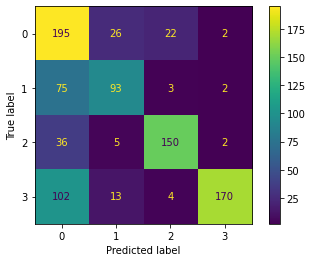

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.41      0.75      0.53        55
           1       0.59      0.38      0.46        42
           2       0.81      0.73      0.77        60
           3       1.00      0.63      0.77        68

    accuracy                           0.64       225
   macro avg       0.70      0.62      0.63       225
weighted avg       0.73      0.64      0.66       225



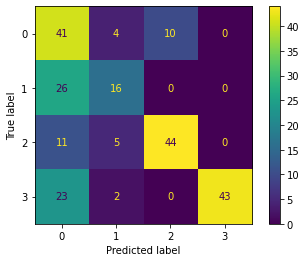

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

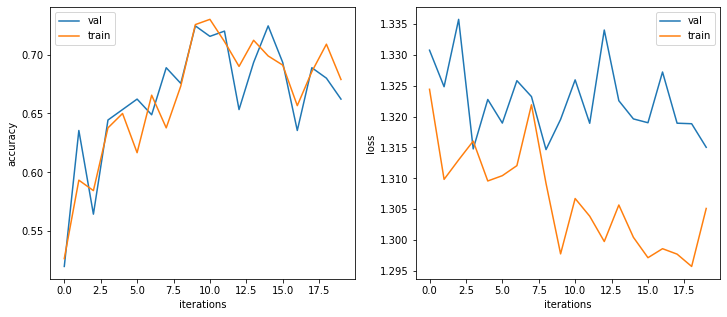

In [ ]:
plotplz()

##***3-layer***

### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(250 * 250 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1               [-1, 187500]               0
            Linear-2                  [-1, 512]      96,000,512
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 128]          65,664
              ReLU-7                  [-1, 128]               0
            Linear-8                    [-1, 4]             516
           Softmax-9                    [-1, 4]               0
Total params: 96,329,348
Trainable params: 96,329,348
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.72
Forward/backward pass size (MB): 1.45
Params size (MB): 367.47
Estimated Total Size (MB): 369.63
---------------------------------

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 60.111    train losses 1.316 --- valid accuracy 65.778   valid losses 1.325
Epoch 2 --- train accuracy 70.222    train losses 1.305 --- valid accuracy 68.444   valid losses 1.318
Epoch 3 --- train accuracy 66.444    train losses 1.309 --- valid accuracy 67.556   valid losses 1.321
Epoch 4 --- train accuracy 69.111    train losses 1.311 --- valid accuracy 73.778   valid losses 1.314
Epoch 5 --- train accuracy 74.000    train losses 1.304 --- valid accuracy 75.556   valid losses 1.319
Epoch 6 --- train accuracy 73.778    train losses 1.299 --- valid accuracy 75.556   valid losses 1.318
Epoch 7 --- train accuracy 77.333    train losses 1.300 --- valid accuracy 76.000   valid losses 1.319
Epoch 8 --- train accuracy 75.111    train losses 1.296 --- valid accuracy 74.222   valid losses 1.318
Epoch 9 --- train accuracy 75.889    train losses 1.302 --- valid accuracy 75.556   valid losses 1.315
Epoch 10 --- train accuracy 75.444    train losses 1.298 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       245
           1       0.46      0.87      0.60       173
           2       0.86      0.78      0.82       193
           3       0.99      0.60      0.74       289

    accuracy                           0.69       900
   macro avg       0.75      0.71      0.70       900
weighted avg       0.77      0.69      0.70       900



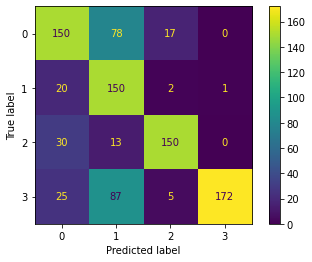

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.56      0.60      0.58        55
           1       0.48      0.86      0.62        42
           2       0.87      0.67      0.75        60
           3       1.00      0.66      0.80        68

    accuracy                           0.68       225
   macro avg       0.73      0.70      0.69       225
weighted avg       0.76      0.68      0.70       225



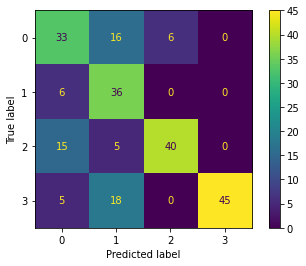

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

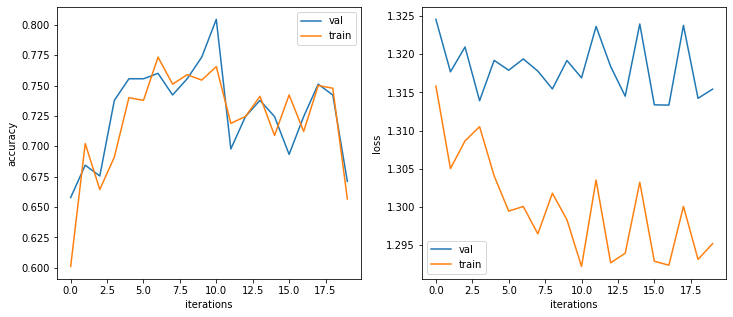

In [ ]:
plotplz()

##***4-layer***

### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(250 * 250 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1               [-1, 187500]               0
            Linear-2                  [-1, 512]      96,000,512
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
           Linear-10                    [-1, 4]             260
          Softmax-11                    [-1, 4]               0
Total params: 96,173,252
Trainable params: 96,173,252
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.72
Fo

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 57.111    train losses 1.319 --- valid accuracy 65.333   valid losses 1.319
Epoch 2 --- train accuracy 65.778    train losses 1.307 --- valid accuracy 72.444   valid losses 1.317
Epoch 3 --- train accuracy 73.667    train losses 1.286 --- valid accuracy 80.000   valid losses 1.317
Epoch 4 --- train accuracy 76.333    train losses 1.305 --- valid accuracy 76.000   valid losses 1.316
Epoch 5 --- train accuracy 75.222    train losses 1.301 --- valid accuracy 77.333   valid losses 1.313
Epoch 6 --- train accuracy 74.000    train losses 1.301 --- valid accuracy 78.222   valid losses 1.314
Epoch 7 --- train accuracy 77.778    train losses 1.292 --- valid accuracy 80.000   valid losses 1.315
Epoch 8 --- train accuracy 79.444    train losses 1.284 --- valid accuracy 84.444   valid losses 1.316
Epoch 9 --- train accuracy 80.778    train losses 1.299 --- valid accuracy 79.556   valid losses 1.313
Epoch 10 --- train accuracy 80.444    train losses 1.298 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.86      0.69      0.77       245
           1       0.80      0.77      0.79       173
           2       0.79      0.95      0.86       193
           3       0.91      0.94      0.93       289

    accuracy                           0.85       900
   macro avg       0.84      0.84      0.84       900
weighted avg       0.85      0.85      0.84       900



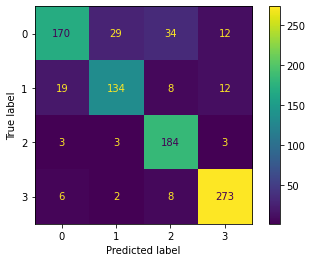

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.72      0.62      0.67        55
           1       0.77      0.79      0.78        42
           2       0.80      0.88      0.84        60
           3       0.93      0.94      0.93        68

    accuracy                           0.82       225
   macro avg       0.81      0.81      0.80       225
weighted avg       0.81      0.82      0.81       225



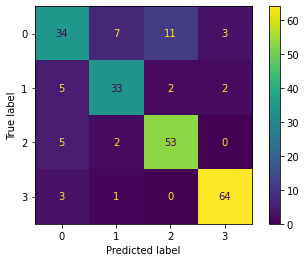

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

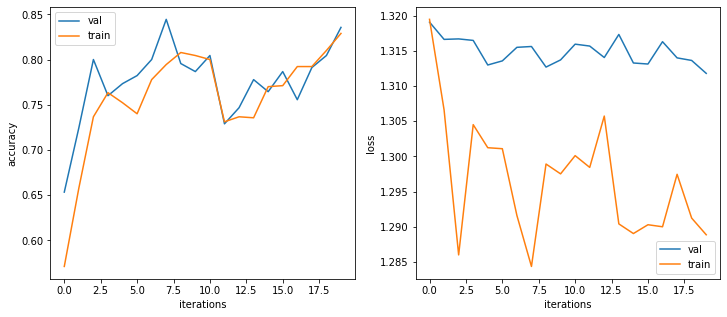

In [ ]:
plotplz()

#***Conv2D***

## Model 1

### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 3, padding = 1, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 3, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, stride = 3, padding = 1, dilation = 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(10368, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 83, 83]           2,432
              ReLU-2           [-1, 32, 83, 83]               0
            Conv2d-3           [-1, 64, 28, 28]          51,264
              ReLU-4           [-1, 64, 28, 28]               0
            Conv2d-5            [-1, 128, 9, 9]         204,928
              ReLU-6            [-1, 128, 9, 9]               0
           Flatten-7                [-1, 10368]               0
            Linear-8                  [-1, 256]       2,654,464
              ReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 4]           1,028
          Softmax-11                    [-1, 4]               0
Total params: 2,914,116
Trainable params: 2,914,116
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.72
Forw

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 62.000    train losses 1.360 --- valid accuracy 60.444   valid losses 1.331
Epoch 2 --- train accuracy 60.667    train losses 1.322 --- valid accuracy 69.778   valid losses 1.317
Epoch 3 --- train accuracy 71.889    train losses 1.306 --- valid accuracy 75.111   valid losses 1.319
Epoch 4 --- train accuracy 77.333    train losses 1.312 --- valid accuracy 78.222   valid losses 1.318
Epoch 5 --- train accuracy 70.889    train losses 1.302 --- valid accuracy 70.222   valid losses 1.317
Epoch 6 --- train accuracy 68.222    train losses 1.301 --- valid accuracy 75.556   valid losses 1.316
Epoch 7 --- train accuracy 75.667    train losses 1.297 --- valid accuracy 77.333   valid losses 1.317
Epoch 8 --- train accuracy 78.000    train losses 1.302 --- valid accuracy 78.667   valid losses 1.315
Epoch 9 --- train accuracy 79.000    train losses 1.299 --- valid accuracy 80.000   valid losses 1.319
Epoch 10 --- train accuracy 81.444    train losses 1.291 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       245
           1       0.49      0.77      0.60       173
           2       0.70      0.92      0.79       193
           3       0.99      0.48      0.65       289

    accuracy                           0.67       900
   macro avg       0.71      0.70      0.67       900
weighted avg       0.74      0.67      0.67       900



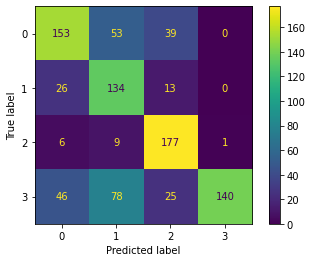

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.60      0.67      0.63        55
           1       0.58      0.76      0.66        42
           2       0.79      0.87      0.83        60
           3       1.00      0.62      0.76        68

    accuracy                           0.72       225
   macro avg       0.74      0.73      0.72       225
weighted avg       0.77      0.72      0.73       225



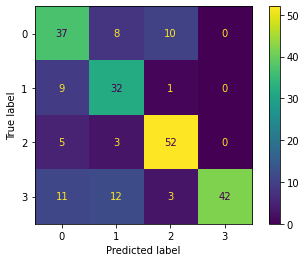

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

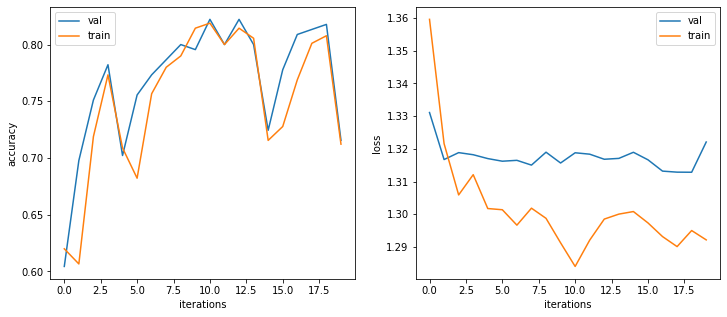

In [ ]:
plotplz()

## Model 2


### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 6, stride = 3, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 2, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 6, stride = 4, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 11 * 11, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 83, 83]           3,488
              ReLU-2           [-1, 32, 83, 83]               0
            Conv2d-3           [-1, 64, 42, 42]          51,264
              ReLU-4           [-1, 64, 42, 42]               0
            Conv2d-5          [-1, 128, 11, 11]         295,040
              ReLU-6          [-1, 128, 11, 11]               0
           Flatten-7                [-1, 15488]               0
            Linear-8                  [-1, 512]       7,930,368
              ReLU-9                  [-1, 512]               0
           Linear-10                  [-1, 128]          65,664
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 4]             516
          Softmax-13                    [-1, 4]               0
Total params: 8,346,340
Trainable param

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 66.000    train losses 1.349 --- valid accuracy 60.444   valid losses 1.328
Epoch 2 --- train accuracy 61.889    train losses 1.307 --- valid accuracy 64.000   valid losses 1.325
Epoch 3 --- train accuracy 63.667    train losses 1.302 --- valid accuracy 70.667   valid losses 1.319
Epoch 4 --- train accuracy 73.333    train losses 1.298 --- valid accuracy 72.000   valid losses 1.319
Epoch 5 --- train accuracy 73.556    train losses 1.305 --- valid accuracy 78.222   valid losses 1.313
Epoch 6 --- train accuracy 74.667    train losses 1.302 --- valid accuracy 74.222   valid losses 1.314
Epoch 7 --- train accuracy 77.556    train losses 1.299 --- valid accuracy 76.889   valid losses 1.315
Epoch 8 --- train accuracy 65.111    train losses 1.317 --- valid accuracy 65.333   valid losses 1.331
Epoch 9 --- train accuracy 69.111    train losses 1.306 --- valid accuracy 69.778   valid losses 1.322
Epoch 10 --- train accuracy 70.222    train losses 1.294 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.79      0.56      0.66       240
           1       0.62      0.51      0.56       166
           2       0.87      0.73      0.79       205
           3       0.68      0.98      0.80       289

    accuracy                           0.73       900
   macro avg       0.74      0.70      0.70       900
weighted avg       0.74      0.73      0.72       900



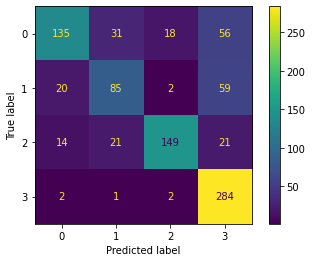

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.73      0.63      0.68        60
           1       0.79      0.47      0.59        49
           2       0.80      0.83      0.82        48
           3       0.67      0.93      0.78        68

    accuracy                           0.73       225
   macro avg       0.75      0.72      0.72       225
weighted avg       0.74      0.73      0.72       225



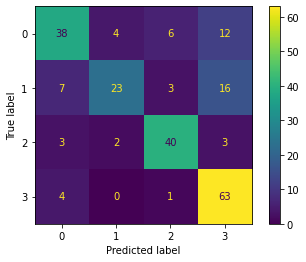

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

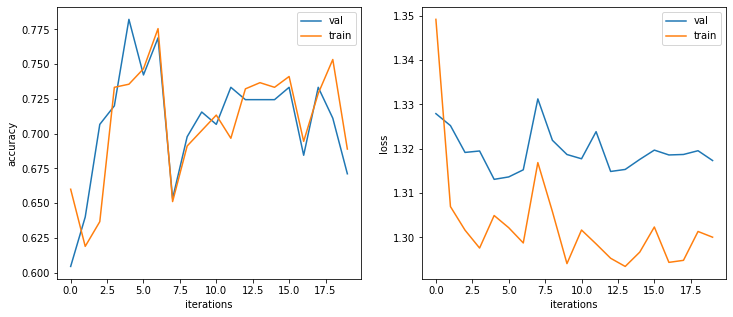

In [ ]:
plotplz()

## Model 3


### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 2, padding = 1, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 3, padding = 1, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, stride = 3, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 124, 124]           2,432
              ReLU-2         [-1, 32, 124, 124]               0
            Conv2d-3           [-1, 64, 41, 41]          51,264
              ReLU-4           [-1, 64, 41, 41]               0
            Conv2d-5          [-1, 128, 14, 14]         204,928
              ReLU-6          [-1, 128, 14, 14]               0
           Flatten-7                [-1, 25088]               0
            Linear-8                  [-1, 512]      12,845,568
              ReLU-9                  [-1, 512]               0
           Linear-10                  [-1, 256]         131,328
             ReLU-11                  [-1, 256]               0
           Linear-12                   [-1, 64]          16,448
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 60.111    train losses 1.358 --- valid accuracy 56.889   valid losses 1.342
Epoch 2 --- train accuracy 53.444    train losses 1.322 --- valid accuracy 63.111   valid losses 1.324
Epoch 3 --- train accuracy 66.667    train losses 1.304 --- valid accuracy 71.556   valid losses 1.320
Epoch 4 --- train accuracy 68.889    train losses 1.302 --- valid accuracy 71.111   valid losses 1.318
Epoch 5 --- train accuracy 72.556    train losses 1.304 --- valid accuracy 74.222   valid losses 1.317
Epoch 6 --- train accuracy 75.667    train losses 1.295 --- valid accuracy 74.222   valid losses 1.318
Epoch 7 --- train accuracy 77.778    train losses 1.294 --- valid accuracy 76.444   valid losses 1.315
Epoch 8 --- train accuracy 78.222    train losses 1.294 --- valid accuracy 74.222   valid losses 1.321
Epoch 9 --- train accuracy 73.222    train losses 1.304 --- valid accuracy 74.667   valid losses 1.321
Epoch 10 --- train accuracy 76.889    train losses 1.308 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       240
           1       0.77      0.58      0.66       166
           2       0.83      0.90      0.86       205
           3       0.92      0.95      0.94       289

    accuracy                           0.82       900
   macro avg       0.81      0.80      0.80       900
weighted avg       0.82      0.82      0.82       900



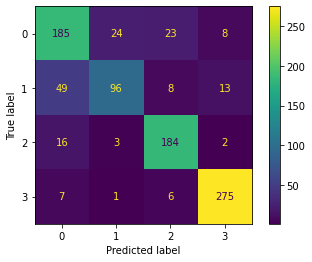

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.70      0.75      0.73        60
           1       0.88      0.57      0.69        49
           2       0.74      0.90      0.81        48
           3       0.87      0.91      0.89        68

    accuracy                           0.79       225
   macro avg       0.80      0.78      0.78       225
weighted avg       0.80      0.79      0.79       225



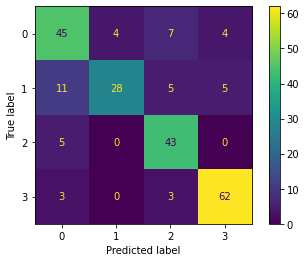

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

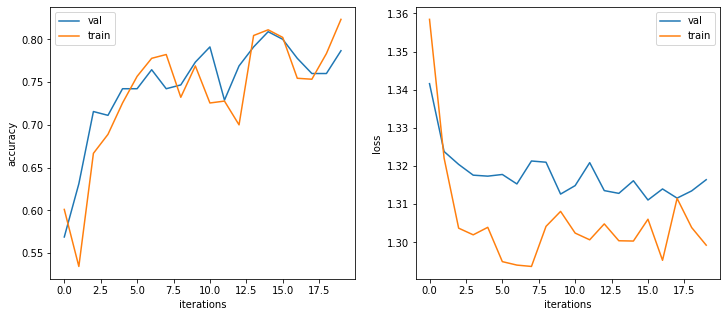

In [ ]:
plotplz()

#***pooling***

## Model 1


### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 1, padding = 'valid', dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 1, padding = 'valid', dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, stride = 1, padding = 'valid', dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 246, 246]           2,432
              ReLU-2         [-1, 32, 246, 246]               0
         MaxPool2d-3           [-1, 32, 82, 82]               0
            Conv2d-4           [-1, 64, 78, 78]          51,264
              ReLU-5           [-1, 64, 78, 78]               0
         MaxPool2d-6           [-1, 64, 26, 26]               0
            Conv2d-7          [-1, 128, 22, 22]         204,928
              ReLU-8          [-1, 128, 22, 22]               0
         MaxPool2d-9            [-1, 128, 7, 7]               0
          Flatten-10                 [-1, 6272]               0
           Linear-11                  [-1, 128]         802,944
             ReLU-12                  [-1, 128]               0
           Linear-13                    [-1, 4]             516
          Softmax-14                   

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 65.000    train losses 1.356 --- valid accuracy 52.000   valid losses 1.340
Epoch 2 --- train accuracy 62.778    train losses 1.317 --- valid accuracy 58.667   valid losses 1.324
Epoch 3 --- train accuracy 71.000    train losses 1.306 --- valid accuracy 68.444   valid losses 1.322
Epoch 4 --- train accuracy 73.778    train losses 1.304 --- valid accuracy 74.667   valid losses 1.323
Epoch 5 --- train accuracy 77.556    train losses 1.304 --- valid accuracy 80.444   valid losses 1.318
Epoch 6 --- train accuracy 76.333    train losses 1.304 --- valid accuracy 80.444   valid losses 1.316
Epoch 7 --- train accuracy 82.667    train losses 1.298 --- valid accuracy 84.889   valid losses 1.322
Epoch 8 --- train accuracy 83.222    train losses 1.292 --- valid accuracy 83.556   valid losses 1.313
Epoch 9 --- train accuracy 84.222    train losses 1.298 --- valid accuracy 84.444   valid losses 1.313
Epoch 10 --- train accuracy 84.333    train losses 1.290 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       241
           1       0.76      0.75      0.76       168
           2       0.75      0.89      0.82       206
           3       0.94      0.94      0.94       285

    accuracy                           0.83       900
   macro avg       0.82      0.82      0.82       900
weighted avg       0.83      0.83      0.83       900



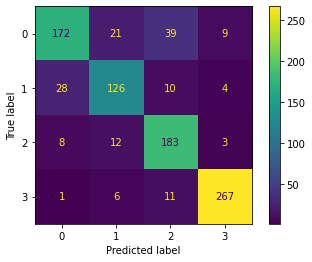

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.86      0.64      0.74        59
           1       0.75      0.83      0.79        47
           2       0.72      0.87      0.79        47
           3       0.99      0.99      0.99        72

    accuracy                           0.84       225
   macro avg       0.83      0.83      0.83       225
weighted avg       0.85      0.84      0.84       225



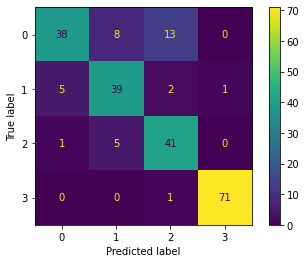

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

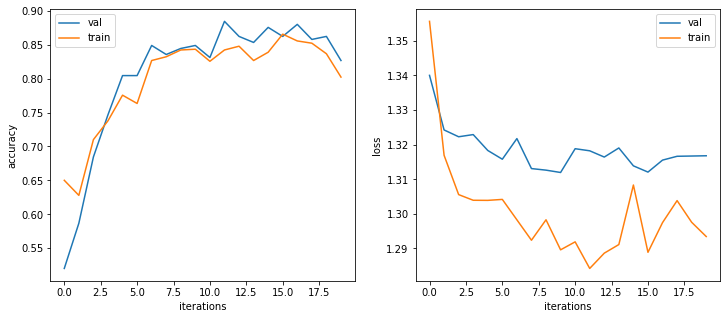

In [ ]:
plotplz()

## Model 2


### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 2, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 4, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Flatten(),
            nn.Linear(4608, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 123, 123]           2,432
              ReLU-2         [-1, 32, 123, 123]               0
         MaxPool2d-3           [-1, 32, 41, 41]               0
            Conv2d-4           [-1, 64, 42, 42]          32,832
              ReLU-5           [-1, 64, 42, 42]               0
         MaxPool2d-6           [-1, 64, 14, 14]               0
            Conv2d-7          [-1, 128, 20, 20]          73,856
              ReLU-8          [-1, 128, 20, 20]               0
         MaxPool2d-9            [-1, 128, 6, 6]               0
          Flatten-10                 [-1, 4608]               0
           Linear-11                  [-1, 512]       2,359,808
             ReLU-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
             ReLU-14                  [

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 60.556    train losses 1.376 --- valid accuracy 65.333   valid losses 1.360
Epoch 2 --- train accuracy 58.556    train losses 1.337 --- valid accuracy 57.778   valid losses 1.345
Epoch 3 --- train accuracy 61.556    train losses 1.314 --- valid accuracy 62.222   valid losses 1.325
Epoch 4 --- train accuracy 65.667    train losses 1.302 --- valid accuracy 66.667   valid losses 1.322
Epoch 5 --- train accuracy 70.222    train losses 1.307 --- valid accuracy 74.667   valid losses 1.322
Epoch 6 --- train accuracy 75.667    train losses 1.289 --- valid accuracy 77.778   valid losses 1.319
Epoch 7 --- train accuracy 76.667    train losses 1.303 --- valid accuracy 75.111   valid losses 1.324
Epoch 8 --- train accuracy 78.333    train losses 1.297 --- valid accuracy 82.667   valid losses 1.318
Epoch 9 --- train accuracy 80.000    train losses 1.301 --- valid accuracy 84.889   valid losses 1.318
Epoch 10 --- train accuracy 81.889    train losses 1.296 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.80      0.65      0.72       241
           1       0.60      0.85      0.70       168
           2       0.83      0.82      0.82       206
           3       0.98      0.92      0.95       285

    accuracy                           0.81       900
   macro avg       0.80      0.81      0.80       900
weighted avg       0.83      0.81      0.81       900



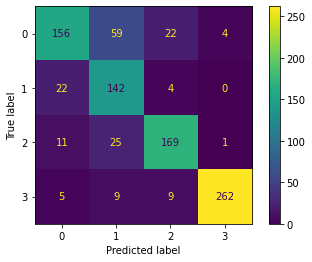

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.85      0.69      0.77        59
           1       0.64      0.83      0.72        47
           2       0.74      0.72      0.73        47
           3       0.99      0.96      0.97        72

    accuracy                           0.81       225
   macro avg       0.80      0.80      0.80       225
weighted avg       0.83      0.81      0.82       225



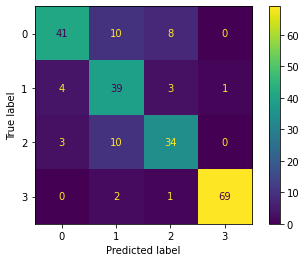

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

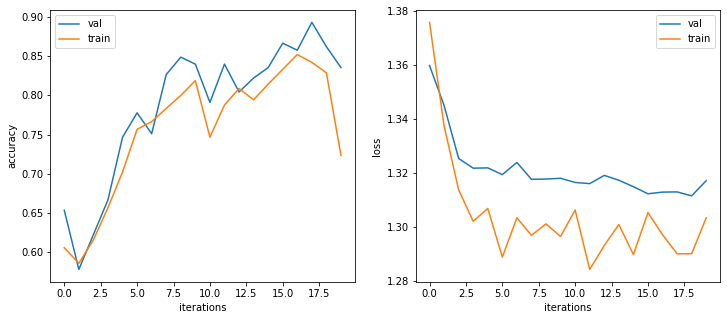

In [ ]:
plotplz()

## Model 3

### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 2, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.AvgPool2d(3),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.AvgPool2d(3),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.AvgPool2d(3),
            nn.Flatten(),
            nn.Linear(6272, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 125, 125]           2,432
              ReLU-2         [-1, 32, 125, 125]               0
         AvgPool2d-3           [-1, 32, 41, 41]               0
            Conv2d-4           [-1, 64, 42, 42]          32,832
              ReLU-5           [-1, 64, 42, 42]               0
         AvgPool2d-6           [-1, 64, 14, 14]               0
            Conv2d-7          [-1, 128, 21, 21]         131,200
              ReLU-8          [-1, 128, 21, 21]               0
         AvgPool2d-9            [-1, 128, 7, 7]               0
          Flatten-10                 [-1, 6272]               0
           Linear-11                  [-1, 512]       3,211,776
             ReLU-12                  [-1, 512]               0
           Linear-13                  [-1, 128]          65,664
             ReLU-14                  [

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 63.111    train losses 1.374 --- valid accuracy 67.556   valid losses 1.361
Epoch 2 --- train accuracy 60.000    train losses 1.332 --- valid accuracy 60.444   valid losses 1.338
Epoch 3 --- train accuracy 56.222    train losses 1.324 --- valid accuracy 56.444   valid losses 1.328
Epoch 4 --- train accuracy 61.222    train losses 1.309 --- valid accuracy 59.556   valid losses 1.320
Epoch 5 --- train accuracy 62.444    train losses 1.304 --- valid accuracy 58.222   valid losses 1.323
Epoch 6 --- train accuracy 66.000    train losses 1.316 --- valid accuracy 69.333   valid losses 1.316
Epoch 7 --- train accuracy 69.000    train losses 1.296 --- valid accuracy 69.778   valid losses 1.316
Epoch 8 --- train accuracy 72.222    train losses 1.311 --- valid accuracy 77.778   valid losses 1.316
Epoch 9 --- train accuracy 76.333    train losses 1.305 --- valid accuracy 78.667   valid losses 1.316
Epoch 10 --- train accuracy 76.889    train losses 1.294 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.78      0.57      0.66       241
           1       0.69      0.76      0.72       168
           2       0.78      0.92      0.84       206
           3       0.91      0.94      0.93       285

    accuracy                           0.80       900
   macro avg       0.79      0.80      0.79       900
weighted avg       0.80      0.80      0.80       900



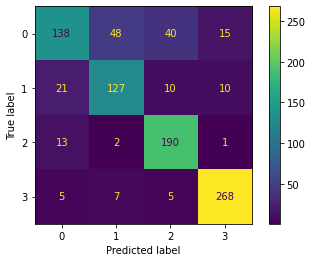

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.76      0.71      0.74        59
           1       0.79      0.66      0.72        47
           2       0.71      0.89      0.79        47
           3       0.97      0.97      0.97        72

    accuracy                           0.82       225
   macro avg       0.81      0.81      0.81       225
weighted avg       0.83      0.82      0.82       225



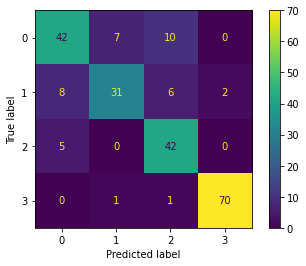

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

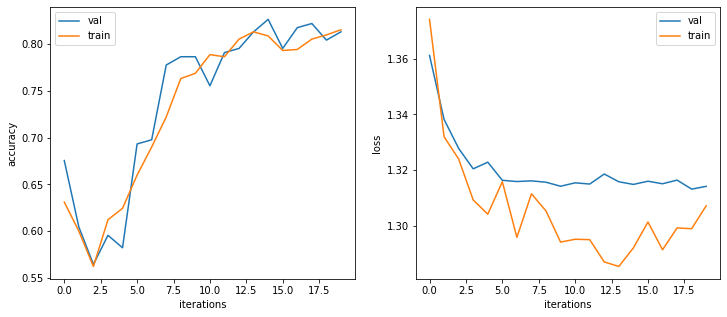

In [ ]:
plotplz()

## With Augmentation


### Training

In [ ]:
trainloader, testloader = get_train_valid_loader("./Multi-class Weather Dataset/", batch_size=32, augment=True, size=250, valid_size=0.2)

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 1, padding = 'valid', dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 1, padding = 'valid', dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, stride = 1, padding = 'valid', dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Flatten(),
            nn.Linear(6272, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 246, 246]           2,432
              ReLU-2         [-1, 32, 246, 246]               0
         MaxPool2d-3           [-1, 32, 82, 82]               0
            Conv2d-4           [-1, 64, 78, 78]          51,264
              ReLU-5           [-1, 64, 78, 78]               0
         MaxPool2d-6           [-1, 64, 26, 26]               0
            Conv2d-7          [-1, 128, 22, 22]         204,928
              ReLU-8          [-1, 128, 22, 22]               0
         MaxPool2d-9            [-1, 128, 7, 7]               0
          Flatten-10                 [-1, 6272]               0
           Linear-11                  [-1, 128]         802,944
             ReLU-12                  [-1, 128]               0
           Linear-13                    [-1, 4]             516
          Softmax-14                   

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 62.333    train losses 1.356 --- valid accuracy 53.778   valid losses 1.343
Epoch 2 --- train accuracy 57.000    train losses 1.316 --- valid accuracy 64.000   valid losses 1.328
Epoch 3 --- train accuracy 68.333    train losses 1.311 --- valid accuracy 69.778   valid losses 1.323
Epoch 4 --- train accuracy 75.444    train losses 1.297 --- valid accuracy 76.889   valid losses 1.318
Epoch 5 --- train accuracy 79.111    train losses 1.301 --- valid accuracy 73.778   valid losses 1.317
Epoch 6 --- train accuracy 83.444    train losses 1.286 --- valid accuracy 79.111   valid losses 1.315
Epoch 7 --- train accuracy 84.444    train losses 1.292 --- valid accuracy 80.444   valid losses 1.317
Epoch 8 --- train accuracy 85.111    train losses 1.291 --- valid accuracy 80.889   valid losses 1.316
Epoch 9 --- train accuracy 84.111    train losses 1.299 --- valid accuracy 76.444   valid losses 1.318
Epoch 10 --- train accuracy 85.778    train losses 1.283 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.86      0.63      0.73       245
           1       0.78      0.74      0.76       162
           2       0.67      0.89      0.76       197
           3       0.95      0.97      0.96       296

    accuracy                           0.82       900
   macro avg       0.81      0.81      0.80       900
weighted avg       0.83      0.82      0.82       900



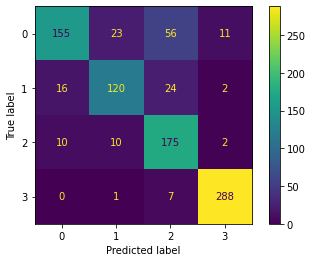

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.68      0.71      0.70        55
           1       0.78      0.66      0.71        53
           2       0.86      0.79      0.82        56
           3       0.83      0.98      0.90        61

    accuracy                           0.79       225
   macro avg       0.79      0.78      0.78       225
weighted avg       0.79      0.79      0.79       225



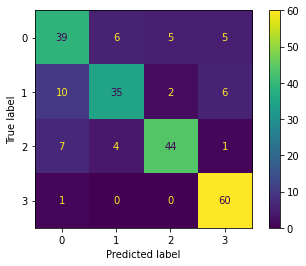

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

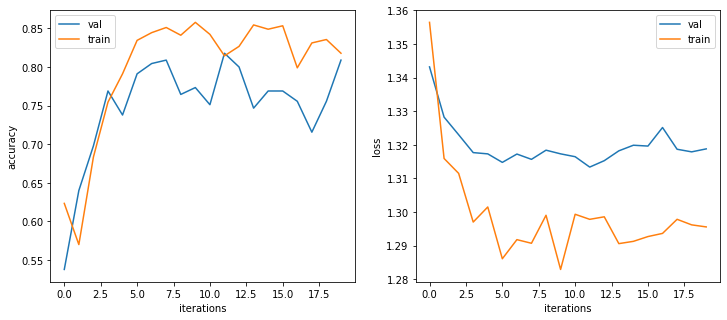

In [ ]:
plotplz()

#***Dropout***

## Model 1

### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 6, stride = 2, padding = 4, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 6, stride = 2, padding = 3, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 6, stride = 1, padding = 3, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(8 * 8 * 128, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 127, 127]           3,488
              ReLU-2         [-1, 32, 127, 127]               0
         MaxPool2d-3           [-1, 32, 63, 63]               0
            Conv2d-4           [-1, 64, 32, 32]          73,792
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 17, 17]         295,040
              ReLU-8          [-1, 128, 17, 17]               0
         MaxPool2d-9            [-1, 128, 8, 8]               0
          Flatten-10                 [-1, 8192]               0
          Dropout-11                 [-1, 8192]               0
           Linear-12                  [-1, 512]       4,194,816
             ReLU-13                  [-1, 512]               0
           Linear-14                  [

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 61.111    train losses 1.370 --- valid accuracy 49.333   valid losses 1.338
Epoch 2 --- train accuracy 53.000    train losses 1.322 --- valid accuracy 58.667   valid losses 1.323
Epoch 3 --- train accuracy 57.778    train losses 1.305 --- valid accuracy 56.889   valid losses 1.319
Epoch 4 --- train accuracy 60.111    train losses 1.306 --- valid accuracy 63.111   valid losses 1.316
Epoch 5 --- train accuracy 63.333    train losses 1.303 --- valid accuracy 66.222   valid losses 1.316
Epoch 6 --- train accuracy 68.111    train losses 1.307 --- valid accuracy 75.111   valid losses 1.316
Epoch 7 --- train accuracy 76.889    train losses 1.297 --- valid accuracy 79.556   valid losses 1.314
Epoch 8 --- train accuracy 79.556    train losses 1.294 --- valid accuracy 81.333   valid losses 1.315
Epoch 9 --- train accuracy 78.556    train losses 1.301 --- valid accuracy 83.111   valid losses 1.314
Epoch 10 --- train accuracy 80.111    train losses 1.295 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       243
           1       0.42      0.76      0.54       176
           2       0.66      0.78      0.71       192
           3       1.00      0.29      0.45       289

    accuracy                           0.63       900
   macro avg       0.70      0.66      0.62       900
weighted avg       0.74      0.63      0.61       900



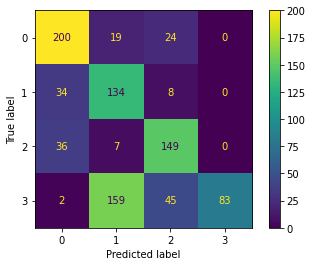

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.68      0.89      0.77        57
           1       0.40      0.79      0.53        39
           2       0.75      0.67      0.71        61
           3       0.94      0.25      0.40        68

    accuracy                           0.62       225
   macro avg       0.69      0.65      0.60       225
weighted avg       0.73      0.62      0.60       225



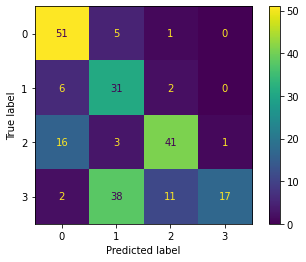

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

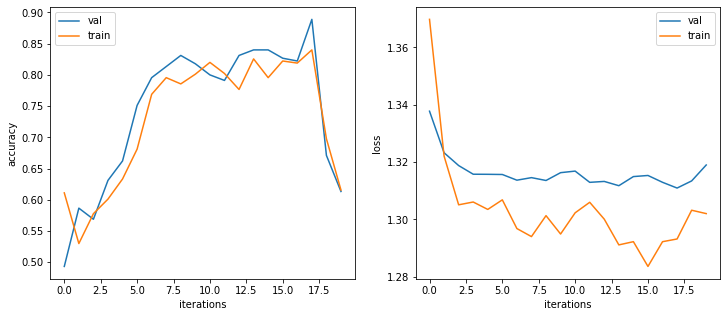

In [ ]:
plotplz()

## Model 2

### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 2, padding = 0, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 2, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, stride = 1, padding = 4, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(9 * 9 * 128, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 123, 123]           2,432
              ReLU-2         [-1, 32, 123, 123]               0
         MaxPool2d-3           [-1, 32, 61, 61]               0
            Conv2d-4           [-1, 64, 31, 31]          51,264
              ReLU-5           [-1, 64, 31, 31]               0
         MaxPool2d-6           [-1, 64, 15, 15]               0
            Conv2d-7          [-1, 128, 19, 19]         204,928
              ReLU-8          [-1, 128, 19, 19]               0
         MaxPool2d-9            [-1, 128, 9, 9]               0
          Flatten-10                [-1, 10368]               0
          Dropout-11                [-1, 10368]               0
           Linear-12                  [-1, 512]       5,308,928
             ReLU-13                  [-1, 512]               0
           Linear-14                  [

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 62.778    train losses 1.361 --- valid accuracy 49.778   valid losses 1.342
Epoch 2 --- train accuracy 57.556    train losses 1.330 --- valid accuracy 56.444   valid losses 1.322
Epoch 3 --- train accuracy 63.333    train losses 1.301 --- valid accuracy 64.889   valid losses 1.322
Epoch 4 --- train accuracy 70.111    train losses 1.314 --- valid accuracy 68.000   valid losses 1.324
Epoch 5 --- train accuracy 70.778    train losses 1.305 --- valid accuracy 64.889   valid losses 1.320
Epoch 6 --- train accuracy 72.667    train losses 1.298 --- valid accuracy 74.667   valid losses 1.315
Epoch 7 --- train accuracy 76.667    train losses 1.300 --- valid accuracy 78.667   valid losses 1.313
Epoch 8 --- train accuracy 75.667    train losses 1.314 --- valid accuracy 76.444   valid losses 1.314
Epoch 9 --- train accuracy 77.778    train losses 1.293 --- valid accuracy 80.000   valid losses 1.313
Epoch 10 --- train accuracy 81.333    train losses 1.299 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       243
           1       0.83      0.76      0.79       176
           2       0.78      0.89      0.83       192
           3       0.99      0.93      0.96       289

    accuracy                           0.86       900
   macro avg       0.85      0.85      0.85       900
weighted avg       0.86      0.86      0.86       900



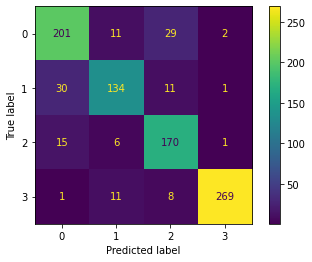

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.77      0.88      0.82        57
           1       0.85      0.72      0.78        39
           2       0.85      0.82      0.83        61
           3       0.93      0.93      0.93        68

    accuracy                           0.85       225
   macro avg       0.85      0.84      0.84       225
weighted avg       0.85      0.85      0.85       225



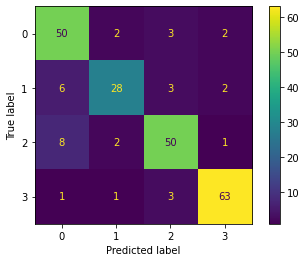

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

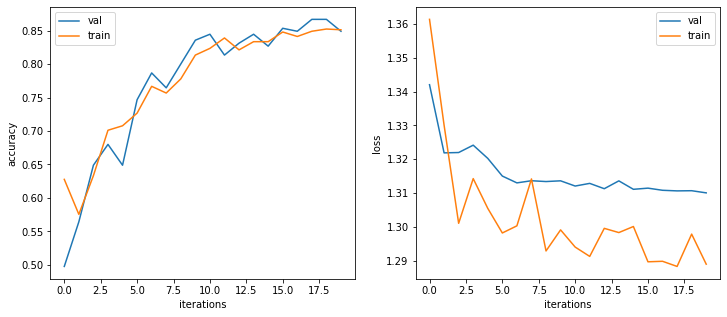

In [ ]:
plotplz()

## Model 3

### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 1, padding = 0, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 1, padding = 0, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, stride = 1, padding = 0, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(7 * 7 * 128, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 246, 246]           2,432
              ReLU-2         [-1, 32, 246, 246]               0
         MaxPool2d-3           [-1, 32, 82, 82]               0
            Conv2d-4           [-1, 64, 78, 78]          51,264
              ReLU-5           [-1, 64, 78, 78]               0
         MaxPool2d-6           [-1, 64, 26, 26]               0
            Conv2d-7          [-1, 128, 22, 22]         204,928
              ReLU-8          [-1, 128, 22, 22]               0
         MaxPool2d-9            [-1, 128, 7, 7]               0
          Flatten-10                 [-1, 6272]               0
          Dropout-11                 [-1, 6272]               0
           Linear-12                  [-1, 512]       3,211,776
             ReLU-13                  [-1, 512]               0
           Linear-14                  [

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 59.111    train losses 1.356 --- valid accuracy 50.667   valid losses 1.342
Epoch 2 --- train accuracy 59.111    train losses 1.315 --- valid accuracy 59.111   valid losses 1.330
Epoch 3 --- train accuracy 60.778    train losses 1.311 --- valid accuracy 64.000   valid losses 1.320
Epoch 4 --- train accuracy 61.556    train losses 1.320 --- valid accuracy 63.111   valid losses 1.325
Epoch 5 --- train accuracy 66.444    train losses 1.316 --- valid accuracy 68.000   valid losses 1.316
Epoch 6 --- train accuracy 68.778    train losses 1.300 --- valid accuracy 72.000   valid losses 1.319
Epoch 7 --- train accuracy 78.222    train losses 1.304 --- valid accuracy 73.778   valid losses 1.314
Epoch 8 --- train accuracy 77.556    train losses 1.304 --- valid accuracy 78.222   valid losses 1.321
Epoch 9 --- train accuracy 78.333    train losses 1.295 --- valid accuracy 78.222   valid losses 1.316
Epoch 10 --- train accuracy 78.556    train losses 1.303 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.76      0.81      0.78       243
           1       0.83      0.68      0.75       176
           2       0.80      0.85      0.83       192
           3       0.95      0.95      0.95       289

    accuracy                           0.84       900
   macro avg       0.83      0.82      0.83       900
weighted avg       0.84      0.84      0.84       900



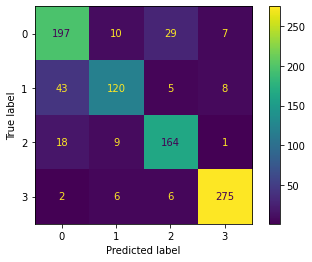

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.73      0.89      0.80        57
           1       0.78      0.74      0.76        39
           2       0.94      0.74      0.83        61
           3       0.93      0.96      0.94        68

    accuracy                           0.84       225
   macro avg       0.84      0.83      0.83       225
weighted avg       0.86      0.84      0.84       225



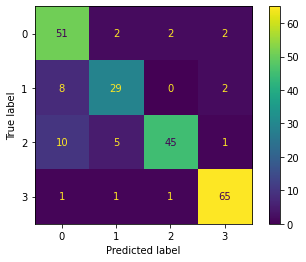

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

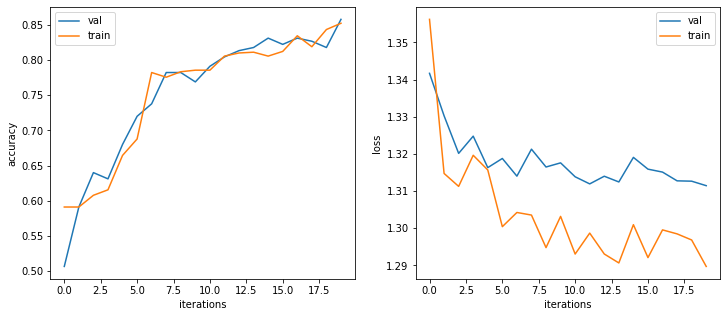

In [ ]:
plotplz()

#***Batch Normalization***

## Model 1

### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1, padding = 3, dilation = 1),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size = 3),
            nn.ReLU(),
            nn.Conv2d(in_channels = 6, out_channels = 8, kernel_size = 4, stride = 1, padding = 3, dilation = 1),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = 4, stride = 1, padding = 3, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Flatten(),
            nn.Linear(5290, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 252, 252]             456
       BatchNorm2d-2          [-1, 6, 252, 252]              12
         MaxPool2d-3            [-1, 6, 84, 84]               0
              ReLU-4            [-1, 6, 84, 84]               0
            Conv2d-5            [-1, 8, 87, 87]             776
       BatchNorm2d-6            [-1, 8, 87, 87]              16
         MaxPool2d-7            [-1, 8, 43, 43]               0
              ReLU-8            [-1, 8, 43, 43]               0
            Conv2d-9           [-1, 10, 46, 46]           1,290
             ReLU-10           [-1, 10, 46, 46]               0
        MaxPool2d-11           [-1, 10, 23, 23]               0
          Flatten-12                 [-1, 5290]               0
           Linear-13                  [-1, 512]       2,708,992
             ReLU-14                  [

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 64.111    train losses 1.357 --- valid accuracy 75.111   valid losses 1.354
Epoch 2 --- train accuracy 66.889    train losses 1.313 --- valid accuracy 75.556   valid losses 1.321
Epoch 3 --- train accuracy 75.778    train losses 1.306 --- valid accuracy 73.778   valid losses 1.316
Epoch 4 --- train accuracy 78.000    train losses 1.301 --- valid accuracy 77.333   valid losses 1.315
Epoch 5 --- train accuracy 81.222    train losses 1.294 --- valid accuracy 82.667   valid losses 1.315
Epoch 6 --- train accuracy 83.333    train losses 1.299 --- valid accuracy 82.667   valid losses 1.312
Epoch 7 --- train accuracy 82.000    train losses 1.298 --- valid accuracy 82.222   valid losses 1.312
Epoch 8 --- train accuracy 82.667    train losses 1.295 --- valid accuracy 82.667   valid losses 1.313
Epoch 9 --- train accuracy 82.778    train losses 1.291 --- valid accuracy 79.111   valid losses 1.317
Epoch 10 --- train accuracy 83.222    train losses 1.296 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.89      0.77      0.82       243
           1       0.68      0.89      0.77       176
           2       0.85      0.82      0.84       192
           3       0.97      0.93      0.95       289

    accuracy                           0.86       900
   macro avg       0.85      0.85      0.85       900
weighted avg       0.87      0.86      0.86       900



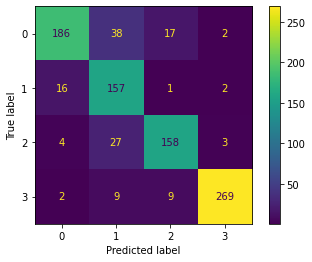

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        57
           1       0.65      0.79      0.71        39
           2       0.90      0.75      0.82        61
           3       0.88      0.87      0.87        68

    accuracy                           0.82       225
   macro avg       0.81      0.82      0.81       225
weighted avg       0.83      0.82      0.82       225



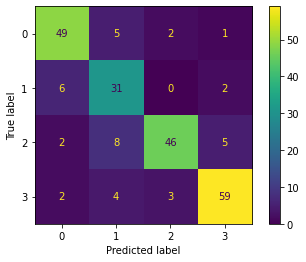

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

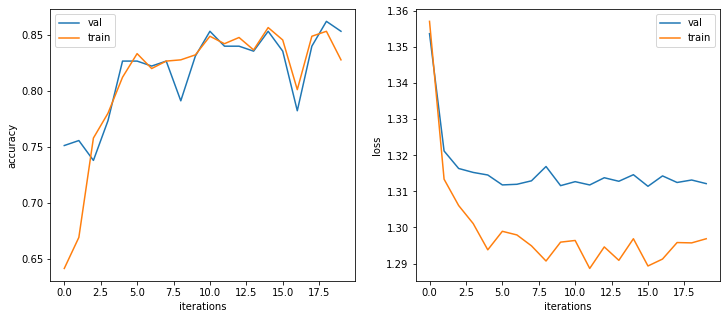

In [ ]:
plotplz()

## Model 2

### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 6, stride = 2, padding = 3, dilation = 1),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size = 3),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = 6, stride = 1, padding = 3, dilation = 1),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 6, stride = 1, padding = 4, dilation = 1),
            nn.BatchNorm2d(20),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2880, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 126, 126]             872
       BatchNorm2d-2          [-1, 8, 126, 126]              16
         MaxPool2d-3            [-1, 8, 42, 42]               0
              ReLU-4            [-1, 8, 42, 42]               0
            Conv2d-5           [-1, 10, 43, 43]           2,890
       BatchNorm2d-6           [-1, 10, 43, 43]              20
         MaxPool2d-7           [-1, 10, 21, 21]               0
              ReLU-8           [-1, 10, 21, 21]               0
            Conv2d-9           [-1, 20, 24, 24]           7,220
      BatchNorm2d-10           [-1, 20, 24, 24]              40
        MaxPool2d-11           [-1, 20, 12, 12]               0
             ReLU-12           [-1, 20, 12, 12]               0
          Flatten-13                 [-1, 2880]               0
           Linear-14                  [

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 68.444    train losses 1.350 --- valid accuracy 75.111   valid losses 1.350
Epoch 2 --- train accuracy 72.444    train losses 1.302 --- valid accuracy 75.556   valid losses 1.322
Epoch 3 --- train accuracy 78.778    train losses 1.293 --- valid accuracy 77.333   valid losses 1.318
Epoch 4 --- train accuracy 79.000    train losses 1.301 --- valid accuracy 80.000   valid losses 1.313
Epoch 5 --- train accuracy 79.889    train losses 1.283 --- valid accuracy 83.111   valid losses 1.315
Epoch 6 --- train accuracy 80.778    train losses 1.297 --- valid accuracy 82.667   valid losses 1.316
Epoch 7 --- train accuracy 84.222    train losses 1.281 --- valid accuracy 84.889   valid losses 1.313
Epoch 8 --- train accuracy 83.556    train losses 1.288 --- valid accuracy 84.444   valid losses 1.313
Epoch 9 --- train accuracy 84.667    train losses 1.280 --- valid accuracy 85.333   valid losses 1.312
Epoch 10 --- train accuracy 86.556    train losses 1.294 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.91      0.83      0.86       243
           1       0.87      0.91      0.89       176
           2       0.83      0.90      0.87       192
           3       0.97      0.96      0.96       289

    accuracy                           0.90       900
   macro avg       0.89      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



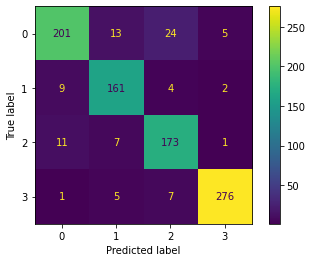

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.91      0.89      0.90        57
           1       0.78      0.92      0.85        39
           2       0.93      0.84      0.88        61
           3       0.96      0.96      0.96        68

    accuracy                           0.90       225
   macro avg       0.89      0.90      0.90       225
weighted avg       0.91      0.90      0.90       225



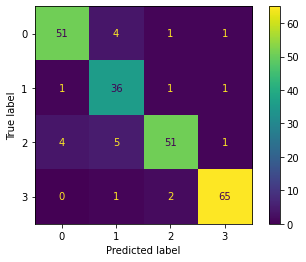

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

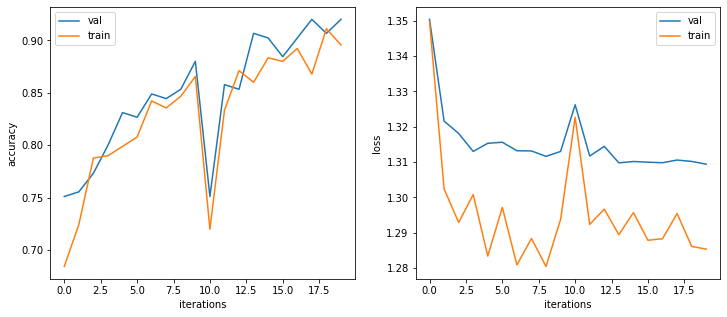

In [ ]:
plotplz()

## Model 3

### Training

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 8, stride = 2, padding = 3, dilation = 1),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size = 3),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = 8, stride = 1, padding = 3, dilation = 1),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 8, stride = 1, padding = 4, dilation = 1),
            nn.BatchNorm2d(20),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 125, 125]           1,544
       BatchNorm2d-2          [-1, 8, 125, 125]              16
         MaxPool2d-3            [-1, 8, 41, 41]               0
              ReLU-4            [-1, 8, 41, 41]               0
            Conv2d-5           [-1, 10, 40, 40]           5,130
       BatchNorm2d-6           [-1, 10, 40, 40]              20
         MaxPool2d-7           [-1, 10, 20, 20]               0
              ReLU-8           [-1, 10, 20, 20]               0
            Conv2d-9           [-1, 20, 21, 21]          12,820
      BatchNorm2d-10           [-1, 20, 21, 21]              40
        MaxPool2d-11           [-1, 20, 10, 10]               0
             ReLU-12           [-1, 20, 10, 10]               0
          Flatten-13                 [-1, 2000]               0
           Linear-14                  [

In [ ]:
model = FCModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 64.444    train losses 1.354 --- valid accuracy 73.333   valid losses 1.349
Epoch 2 --- train accuracy 71.444    train losses 1.317 --- valid accuracy 66.222   valid losses 1.330
Epoch 3 --- train accuracy 76.111    train losses 1.306 --- valid accuracy 76.000   valid losses 1.323
Epoch 4 --- train accuracy 76.778    train losses 1.310 --- valid accuracy 78.667   valid losses 1.316
Epoch 5 --- train accuracy 80.222    train losses 1.298 --- valid accuracy 77.778   valid losses 1.315
Epoch 6 --- train accuracy 80.889    train losses 1.291 --- valid accuracy 81.333   valid losses 1.312
Epoch 7 --- train accuracy 81.111    train losses 1.291 --- valid accuracy 83.556   valid losses 1.314
Epoch 8 --- train accuracy 81.778    train losses 1.290 --- valid accuracy 81.778   valid losses 1.311
Epoch 9 --- train accuracy 81.333    train losses 1.292 --- valid accuracy 80.000   valid losses 1.313
Epoch 10 --- train accuracy 81.667    train losses 1.289 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       243
           1       0.96      0.62      0.75       176
           2       0.82      0.91      0.86       192
           3       0.91      0.95      0.93       289

    accuracy                           0.86       900
   macro avg       0.87      0.84      0.84       900
weighted avg       0.87      0.86      0.86       900



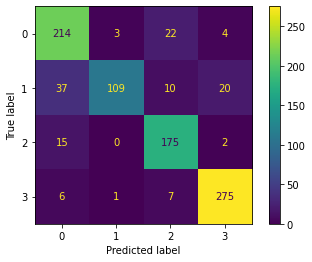

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.71      0.95      0.81        57
           1       0.95      0.46      0.62        39
           2       0.88      0.85      0.87        61
           3       0.89      0.93      0.91        68

    accuracy                           0.83       225
   macro avg       0.86      0.80      0.80       225
weighted avg       0.85      0.83      0.82       225



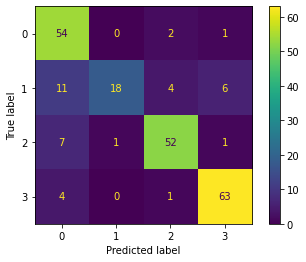

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

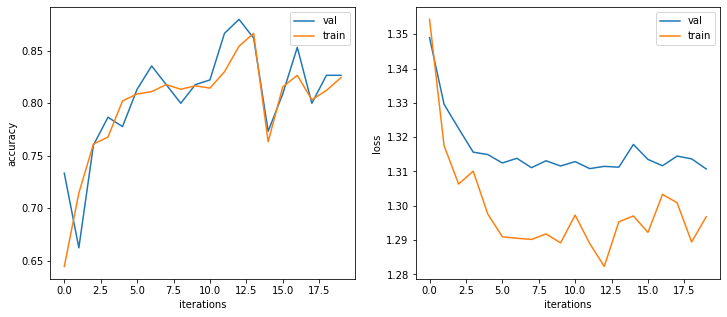

In [ ]:
plotplz()

#***ResNet***

## Model 1

### Implementation

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=1000):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input

### Training

In [ ]:
from torchsummary import summary

model = ResNet18(3, ResBlock, outputs=4).to(device)
summary(model, (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           9,472
         MaxPool2d-2           [-1, 64, 63, 63]               0
       BatchNorm2d-3           [-1, 64, 63, 63]             128
              ReLU-4           [-1, 64, 63, 63]               0
            Conv2d-5           [-1, 64, 63, 63]          36,928
       BatchNorm2d-6           [-1, 64, 63, 63]             128
            Conv2d-7           [-1, 64, 63, 63]          36,928
       BatchNorm2d-8           [-1, 64, 63, 63]             128
          ResBlock-9           [-1, 64, 63, 63]               0
           Conv2d-10           [-1, 64, 63, 63]          36,928
      BatchNorm2d-11           [-1, 64, 63, 63]             128
           Conv2d-12           [-1, 64, 63, 63]          36,928
      BatchNorm2d-13           [-1, 64, 63, 63]             128
         ResBlock-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 79.333    train losses 0.525 --- valid accuracy 64.889   valid losses 0.953
Epoch 2 --- train accuracy 87.111    train losses 0.318 --- valid accuracy 82.667   valid losses 0.477
Epoch 3 --- train accuracy 90.444    train losses 0.289 --- valid accuracy 85.778   valid losses 0.303
Epoch 4 --- train accuracy 89.556    train losses 0.279 --- valid accuracy 85.778   valid losses 0.968
Epoch 5 --- train accuracy 89.667    train losses 0.312 --- valid accuracy 93.333   valid losses 0.183
Epoch 6 --- train accuracy 94.556    train losses 0.142 --- valid accuracy 89.333   valid losses 0.294
Epoch 7 --- train accuracy 94.333    train losses 0.161 --- valid accuracy 92.889   valid losses 0.180
Epoch 8 --- train accuracy 93.444    train losses 0.209 --- valid accuracy 94.667   valid losses 0.194
Epoch 9 --- train accuracy 94.333    train losses 0.145 --- valid accuracy 94.222   valid losses 0.137
Epoch 10 --- train accuracy 96.222    train losses 0.099 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       240
           1       1.00      0.94      0.97       170
           2       0.98      1.00      0.99       206
           3       1.00      0.98      0.99       284

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



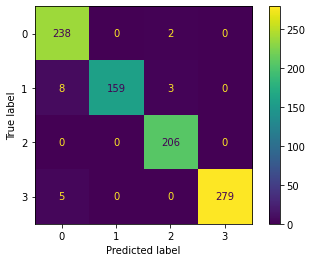

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        60
           1       1.00      0.91      0.95        45
           2       0.90      0.96      0.93        47
           3       0.99      0.96      0.97        73

    accuracy                           0.95       225
   macro avg       0.95      0.94      0.95       225
weighted avg       0.95      0.95      0.95       225



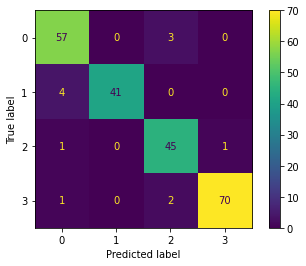

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

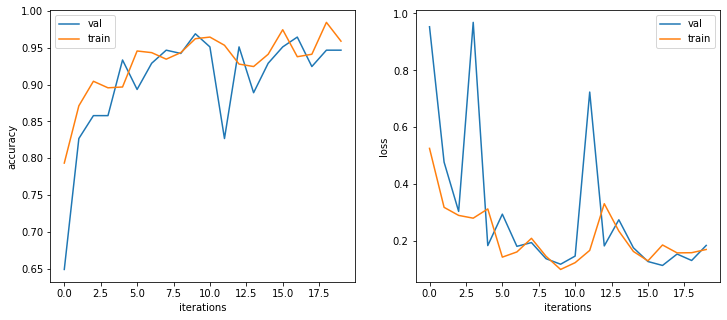

In [ ]:
plotplz()

## Model 2

### Implementation

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=1000):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=8, stride=3, padding=3),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input

### Training

In [ ]:
from torchsummary import summary

model = ResNet18(3, ResBlock, outputs=4).to(device)
summary(model, (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 83, 83]          12,352
         MaxPool2d-2           [-1, 64, 42, 42]               0
       BatchNorm2d-3           [-1, 64, 42, 42]             128
              ReLU-4           [-1, 64, 42, 42]               0
            Conv2d-5           [-1, 64, 42, 42]          36,928
       BatchNorm2d-6           [-1, 64, 42, 42]             128
            Conv2d-7           [-1, 64, 42, 42]          36,928
       BatchNorm2d-8           [-1, 64, 42, 42]             128
          ResBlock-9           [-1, 64, 42, 42]               0
           Conv2d-10           [-1, 64, 42, 42]          36,928
      BatchNorm2d-11           [-1, 64, 42, 42]             128
           Conv2d-12           [-1, 64, 42, 42]          36,928
      BatchNorm2d-13           [-1, 64, 42, 42]             128
         ResBlock-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 78.667    train losses 0.631 --- valid accuracy 57.333   valid losses 1.145
Epoch 2 --- train accuracy 89.222    train losses 0.311 --- valid accuracy 89.333   valid losses 0.258
Epoch 3 --- train accuracy 90.222    train losses 0.316 --- valid accuracy 80.889   valid losses 0.568
Epoch 4 --- train accuracy 88.111    train losses 0.421 --- valid accuracy 86.667   valid losses 0.332
Epoch 5 --- train accuracy 91.889    train losses 0.244 --- valid accuracy 88.444   valid losses 0.267
Epoch 6 --- train accuracy 93.333    train losses 0.289 --- valid accuracy 91.111   valid losses 0.224
Epoch 7 --- train accuracy 94.556    train losses 0.163 --- valid accuracy 91.111   valid losses 0.205
Epoch 8 --- train accuracy 97.778    train losses 0.127 --- valid accuracy 90.222   valid losses 0.303
Epoch 9 --- train accuracy 95.667    train losses 0.121 --- valid accuracy 90.667   valid losses 0.363
Epoch 10 --- train accuracy 97.333    train losses 0.094 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       237
           1       1.00      1.00      1.00       175
           2       1.00      1.00      1.00       194
           3       1.00      1.00      1.00       294

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



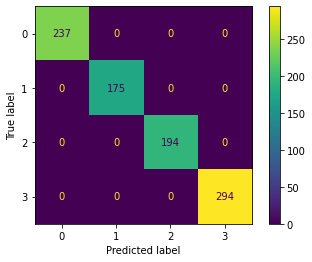

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        63
           1       0.93      0.93      0.93        40
           2       0.87      0.90      0.88        59
           3       0.98      0.95      0.97        63

    accuracy                           0.92       225
   macro avg       0.92      0.92      0.92       225
weighted avg       0.92      0.92      0.92       225



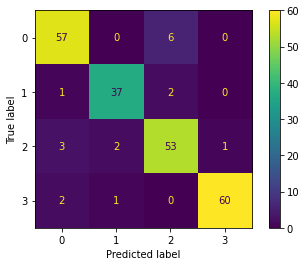

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

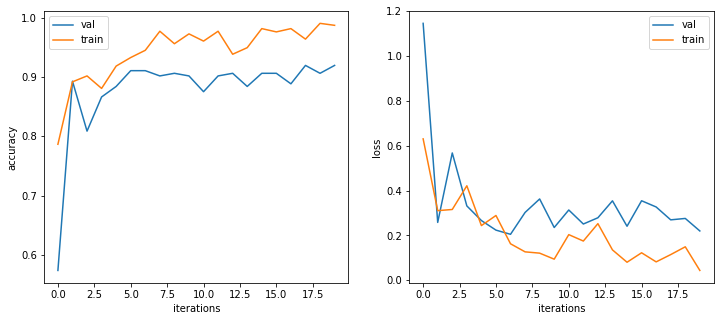

In [ ]:
plotplz()

## Model 3

### Implementation

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=1000):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=10, stride=1, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input

### Training

In [ ]:
from torchsummary import summary

model = ResNet18(3, ResBlock, outputs=4).to(device)
summary(model, (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 247, 247]          19,264
         MaxPool2d-2           [-1, 64, 83, 83]               0
       BatchNorm2d-3           [-1, 64, 83, 83]             128
              ReLU-4           [-1, 64, 83, 83]               0
            Conv2d-5           [-1, 64, 83, 83]          36,928
       BatchNorm2d-6           [-1, 64, 83, 83]             128
            Conv2d-7           [-1, 64, 83, 83]          36,928
       BatchNorm2d-8           [-1, 64, 83, 83]             128
          ResBlock-9           [-1, 64, 83, 83]               0
           Conv2d-10           [-1, 64, 83, 83]          36,928
      BatchNorm2d-11           [-1, 64, 83, 83]             128
           Conv2d-12           [-1, 64, 83, 83]          36,928
      BatchNorm2d-13           [-1, 64, 83, 83]             128
         ResBlock-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 76.556    train losses 0.618 --- valid accuracy 69.778   valid losses 0.843
Epoch 2 --- train accuracy 86.778    train losses 0.375 --- valid accuracy 91.111   valid losses 0.213
Epoch 3 --- train accuracy 89.111    train losses 0.300 --- valid accuracy 86.667   valid losses 1.073
Epoch 4 --- train accuracy 91.000    train losses 0.313 --- valid accuracy 94.667   valid losses 0.204
Epoch 5 --- train accuracy 92.000    train losses 0.235 --- valid accuracy 92.000   valid losses 0.230
Epoch 6 --- train accuracy 91.333    train losses 0.250 --- valid accuracy 92.889   valid losses 0.194
Epoch 7 --- train accuracy 91.889    train losses 0.224 --- valid accuracy 93.333   valid losses 0.164
Epoch 8 --- train accuracy 93.222    train losses 0.192 --- valid accuracy 94.667   valid losses 0.173
Epoch 9 --- train accuracy 94.222    train losses 0.175 --- valid accuracy 93.333   valid losses 0.205
Epoch 10 --- train accuracy 91.889    train losses 0.228 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       240
           1       0.97      0.98      0.97       170
           2       0.94      0.98      0.96       206
           3       1.00      0.99      0.99       284

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



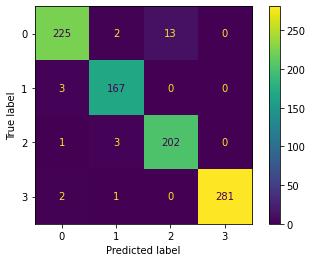

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.93      0.90      0.92        60
           1       0.98      0.96      0.97        45
           2       0.90      0.96      0.93        47
           3       0.99      0.99      0.99        73

    accuracy                           0.95       225
   macro avg       0.95      0.95      0.95       225
weighted avg       0.95      0.95      0.95       225



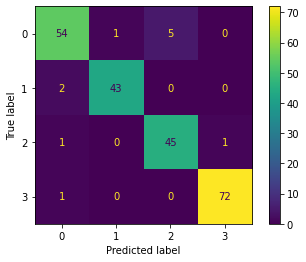

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

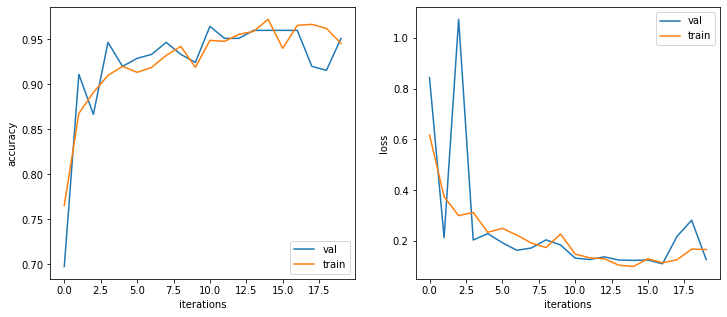

In [ ]:
plotplz()

## Resnet with Augmentation

### Training

In [ ]:
from torchsummary import summary

trainloader, testloader = get_train_valid_loader("./Multi-class Weather Dataset/", batch_size=32, augment=True, size=250, valid_size=0.2)

model = ResNet18(3, ResBlock, outputs=4).to(device)
summary(model, (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           9,472
         MaxPool2d-2           [-1, 64, 63, 63]               0
       BatchNorm2d-3           [-1, 64, 63, 63]             128
              ReLU-4           [-1, 64, 63, 63]               0
            Conv2d-5           [-1, 64, 63, 63]          36,928
       BatchNorm2d-6           [-1, 64, 63, 63]             128
            Conv2d-7           [-1, 64, 63, 63]          36,928
       BatchNorm2d-8           [-1, 64, 63, 63]             128
          ResBlock-9           [-1, 64, 63, 63]               0
           Conv2d-10           [-1, 64, 63, 63]          36,928
      BatchNorm2d-11           [-1, 64, 63, 63]             128
           Conv2d-12           [-1, 64, 63, 63]          36,928
      BatchNorm2d-13           [-1, 64, 63, 63]             128
         ResBlock-14           [-1, 64,

In [ ]:
# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 81.222    train losses 0.557 --- valid accuracy 86.667   valid losses 0.459
Epoch 2 --- train accuracy 82.556    train losses 0.551 --- valid accuracy 85.778   valid losses 0.398
Epoch 3 --- train accuracy 81.444    train losses 0.511 --- valid accuracy 89.778   valid losses 0.436
Epoch 4 --- train accuracy 81.556    train losses 0.527 --- valid accuracy 78.222   valid losses 0.530
Epoch 5 --- train accuracy 80.667    train losses 0.533 --- valid accuracy 87.111   valid losses 0.423
Epoch 6 --- train accuracy 83.556    train losses 0.437 --- valid accuracy 88.889   valid losses 0.348
Epoch 7 --- train accuracy 82.778    train losses 0.459 --- valid accuracy 88.889   valid losses 0.367
Epoch 8 --- train accuracy 84.556    train losses 0.488 --- valid accuracy 88.000   valid losses 0.416
Epoch 9 --- train accuracy 83.889    train losses 0.488 --- valid accuracy 84.444   valid losses 0.568
Epoch 10 --- train accuracy 84.444    train losses 0.438 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       240
           1       0.97      0.98      0.97       170
           2       0.94      0.98      0.96       206
           3       1.00      0.99      0.99       284

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



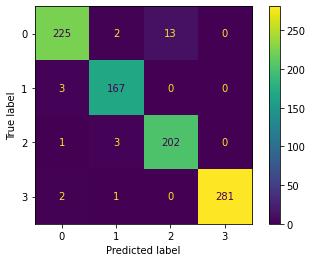

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.93      0.90      0.92        60
           1       0.98      0.96      0.97        45
           2       0.90      0.96      0.93        47
           3       0.99      0.99      0.99        73

    accuracy                           0.95       225
   macro avg       0.95      0.95      0.95       225
weighted avg       0.95      0.95      0.95       225



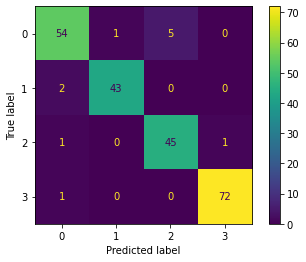

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

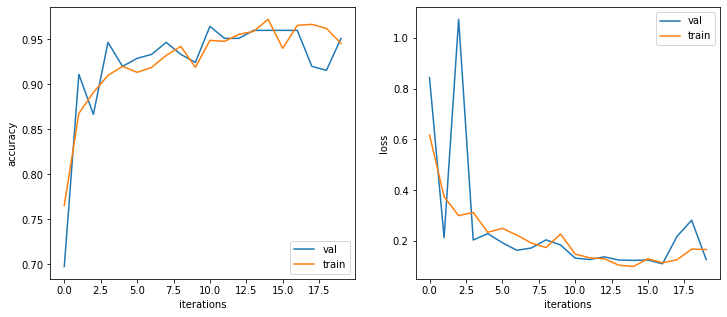

In [ ]:
plotplz()

#***Inception Network***

## Model 1

### Implementation

In [ ]:
class InceptionA(nn.Module):

    def __init__(self, in_channels, pool_features, reverse=False):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):

    def __init__(self, in_channels):
        super(InceptionB, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):

    def __init__(self, in_channels, channels_7x7):
        super(InceptionC, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)

class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [ ]:
class Inception3(nn.Module):

    def __init__(self, outputs=1000):
        super(Inception3, self).__init__()
        self.outputs = outputs
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)
        self.fc = nn.Linear(768, outputs)

    def forward(self, x):
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = F.avg_pool2d(x, kernel_size=8)
        x = F.dropout(x, training=self.training)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

### Training

In [ ]:
from torchsummary import summary

model = Inception3(outputs=4).to(device)
summary(model, (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 124, 124]             864
       BatchNorm2d-2         [-1, 32, 124, 124]              64
       BasicConv2d-3         [-1, 32, 124, 124]               0
            Conv2d-4         [-1, 32, 122, 122]           9,216
       BatchNorm2d-5         [-1, 32, 122, 122]              64
       BasicConv2d-6         [-1, 32, 122, 122]               0
            Conv2d-7         [-1, 64, 122, 122]          18,432
       BatchNorm2d-8         [-1, 64, 122, 122]             128
       BasicConv2d-9         [-1, 64, 122, 122]               0
           Conv2d-10           [-1, 80, 60, 60]           5,120
      BatchNorm2d-11           [-1, 80, 60, 60]             160
      BasicConv2d-12           [-1, 80, 60, 60]               0
           Conv2d-13          [-1, 192, 58, 58]         138,240
      BatchNorm2d-14          [-1, 192,

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 10)

Epoch 1 --- train accuracy 94.889    train losses 0.178 --- valid accuracy 88.889   valid losses 0.274
Epoch 2 --- train accuracy 96.111    train losses 0.147 --- valid accuracy 94.222   valid losses 0.193
Epoch 3 --- train accuracy 94.889    train losses 0.160 --- valid accuracy 92.889   valid losses 0.170
Epoch 4 --- train accuracy 96.556    train losses 0.108 --- valid accuracy 93.333   valid losses 0.200
Epoch 5 --- train accuracy 96.556    train losses 0.102 --- valid accuracy 93.333   valid losses 0.190
Epoch 6 --- train accuracy 97.000    train losses 0.161 --- valid accuracy 92.889   valid losses 0.191
Epoch 7 --- train accuracy 96.889    train losses 0.168 --- valid accuracy 90.667   valid losses 0.539
Epoch 8 --- train accuracy 94.889    train losses 0.236 --- valid accuracy 93.778   valid losses 0.181
Epoch 9 --- train accuracy 96.333    train losses 0.126 --- valid accuracy 93.333   valid losses 0.290
Epoch 10 --- train accuracy 95.556    train losses 0.142 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       237
           1       0.97      1.00      0.99       176
           2       0.98      0.98      0.98       213
           3       1.00      1.00      1.00       274

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



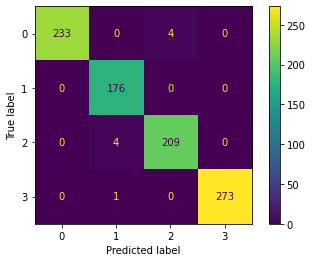

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.96      0.87      0.92        63
           1       0.93      0.97      0.95        39
           2       0.84      0.93      0.88        40
           3       1.00      1.00      1.00        83

    accuracy                           0.95       225
   macro avg       0.93      0.94      0.94       225
weighted avg       0.95      0.95      0.95       225



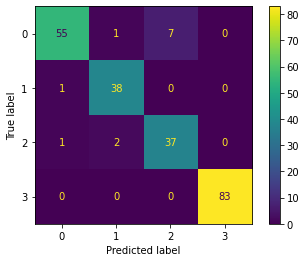

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

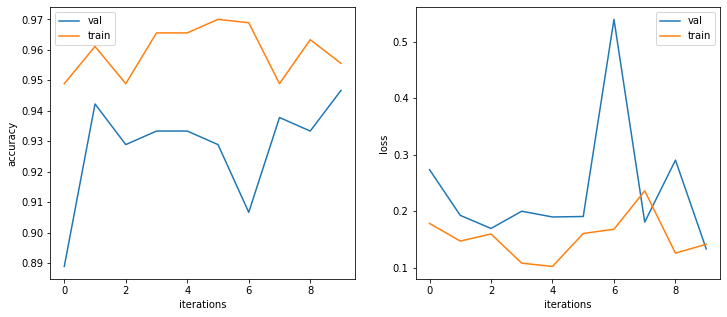

In [ ]:
plotplz()

## Model 2

### Implementation

In [ ]:
class InceptionA(nn.Module):

    def __init__(self, in_channels, pool_features, reverse=False):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):

    def __init__(self, in_channels):
        super(InceptionB, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):

    def __init__(self, in_channels, channels_7x7):
        super(InceptionC, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)

class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [ ]:
class Inception3(nn.Module):

    def __init__(self, outputs=1000):
        super(Inception3, self).__init__()
        self.outputs = outputs
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=5, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=5)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=5, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=5)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)
        self.fc = nn.Linear(768, outputs)

    def forward(self, x):
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = F.avg_pool2d(x, kernel_size=8)
        x = F.dropout(x, training=self.training)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

### Training

In [ ]:
from torchsummary import summary

model = Inception3(outputs=4).to(device)
summary(model, (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 123, 123]           2,400
       BatchNorm2d-2         [-1, 32, 123, 123]              64
       BasicConv2d-3         [-1, 32, 123, 123]               0
            Conv2d-4         [-1, 32, 119, 119]          25,600
       BatchNorm2d-5         [-1, 32, 119, 119]              64
       BasicConv2d-6         [-1, 32, 119, 119]               0
            Conv2d-7         [-1, 64, 117, 117]          51,200
       BatchNorm2d-8         [-1, 64, 117, 117]             128
       BasicConv2d-9         [-1, 64, 117, 117]               0
           Conv2d-10           [-1, 80, 58, 58]           5,120
      BatchNorm2d-11           [-1, 80, 58, 58]             160
      BasicConv2d-12           [-1, 80, 58, 58]               0
           Conv2d-13          [-1, 192, 54, 54]         384,000
      BatchNorm2d-14          [-1, 192,

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 10)

Epoch 1 --- train accuracy 76.889    train losses 0.684 --- valid accuracy 21.333   valid losses 3.128
Epoch 2 --- train accuracy 87.000    train losses 0.388 --- valid accuracy 86.222   valid losses 0.306
Epoch 3 --- train accuracy 91.333    train losses 0.307 --- valid accuracy 83.111   valid losses 0.363
Epoch 4 --- train accuracy 89.889    train losses 0.299 --- valid accuracy 90.667   valid losses 0.244
Epoch 5 --- train accuracy 90.556    train losses 0.279 --- valid accuracy 92.889   valid losses 0.407
Epoch 6 --- train accuracy 92.333    train losses 0.219 --- valid accuracy 92.444   valid losses 0.813
Epoch 7 --- train accuracy 88.889    train losses 0.304 --- valid accuracy 92.000   valid losses 0.223
Epoch 8 --- train accuracy 92.778    train losses 0.276 --- valid accuracy 92.889   valid losses 0.237
Epoch 9 --- train accuracy 90.778    train losses 0.293 --- valid accuracy 88.000   valid losses 0.302
Epoch 10 --- train accuracy 93.111    train losses 0.218 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       237
           1       0.99      0.98      0.99       176
           2       0.95      0.90      0.92       213
           3       0.93      1.00      0.96       274

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



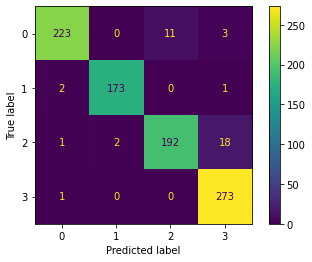

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.95      0.84      0.89        63
           1       1.00      0.92      0.96        39
           2       0.74      0.88      0.80        40
           3       0.95      0.99      0.97        83

    accuracy                           0.92       225
   macro avg       0.91      0.91      0.91       225
weighted avg       0.92      0.92      0.92       225



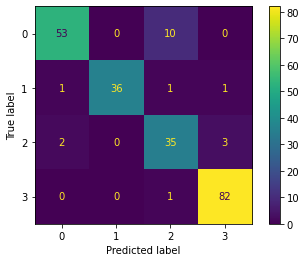

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

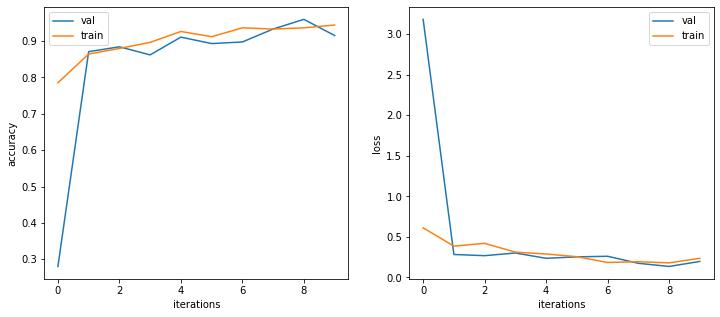

In [ ]:
plotplz()

## Model 3

### Implementation

In [ ]:
class InceptionA(nn.Module):

    def __init__(self, in_channels, pool_features, reverse=False):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):

    def __init__(self, in_channels):
        super(InceptionB, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):

    def __init__(self, in_channels, channels_7x7):
        super(InceptionC, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)

class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [ ]:
class Inception3(nn.Module):

    def __init__(self, outputs=1000):
        super(Inception3, self).__init__()
        self.outputs = outputs
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=8, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=8)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=8, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size =8)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)
        self.fc = nn.Linear(768, outputs)

    def forward(self, x):
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = F.avg_pool2d(x, kernel_size=8)
        x = F.dropout(x, training=self.training)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

### Training

In [ ]:
from torchsummary import summary

model = Inception3(outputs=4).to(device)
summary(model, (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 122, 122]           6,144
       BatchNorm2d-2         [-1, 32, 122, 122]              64
       BasicConv2d-3         [-1, 32, 122, 122]               0
            Conv2d-4         [-1, 32, 115, 115]          65,536
       BatchNorm2d-5         [-1, 32, 115, 115]              64
       BasicConv2d-6         [-1, 32, 115, 115]               0
            Conv2d-7         [-1, 64, 110, 110]         131,072
       BatchNorm2d-8         [-1, 64, 110, 110]             128
       BasicConv2d-9         [-1, 64, 110, 110]               0
           Conv2d-10           [-1, 80, 54, 54]           5,120
      BatchNorm2d-11           [-1, 80, 54, 54]             160
      BasicConv2d-12           [-1, 80, 54, 54]               0
           Conv2d-13          [-1, 192, 47, 47]         983,040
      BatchNorm2d-14          [-1, 192,

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 10)

Epoch 1 --- train accuracy 77.333    train losses 0.655 --- valid accuracy 28.000   valid losses 2.997
Epoch 2 --- train accuracy 87.333    train losses 0.444 --- valid accuracy 88.444   valid losses 0.299
Epoch 3 --- train accuracy 88.667    train losses 0.352 --- valid accuracy 86.667   valid losses 0.479
Epoch 4 --- train accuracy 89.889    train losses 0.380 --- valid accuracy 90.222   valid losses 0.388
Epoch 5 --- train accuracy 90.000    train losses 0.275 --- valid accuracy 90.222   valid losses 0.271
Epoch 6 --- train accuracy 89.111    train losses 0.296 --- valid accuracy 91.111   valid losses 0.231
Epoch 7 --- train accuracy 92.111    train losses 0.279 --- valid accuracy 89.333   valid losses 0.236
Epoch 8 --- train accuracy 93.444    train losses 0.309 --- valid accuracy 88.889   valid losses 0.294
Epoch 9 --- train accuracy 92.111    train losses 0.264 --- valid accuracy 88.889   valid losses 0.327
Epoch 10 --- train accuracy 88.889    train losses 0.347 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       237
           1       0.95      0.96      0.96       176
           2       0.93      0.88      0.90       213
           3       0.95      0.98      0.96       274

    accuracy                           0.95       900
   macro avg       0.95      0.94      0.94       900
weighted avg       0.95      0.95      0.95       900



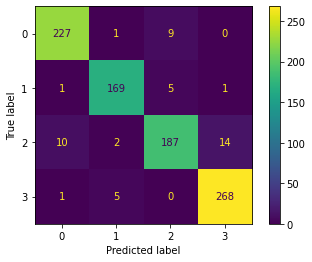

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.90      0.89      0.90        63
           1       0.86      0.95      0.90        39
           2       0.84      0.80      0.82        40
           3       0.99      0.98      0.98        83

    accuracy                           0.92       225
   macro avg       0.90      0.90      0.90       225
weighted avg       0.92      0.92      0.92       225



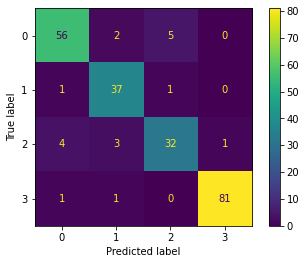

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

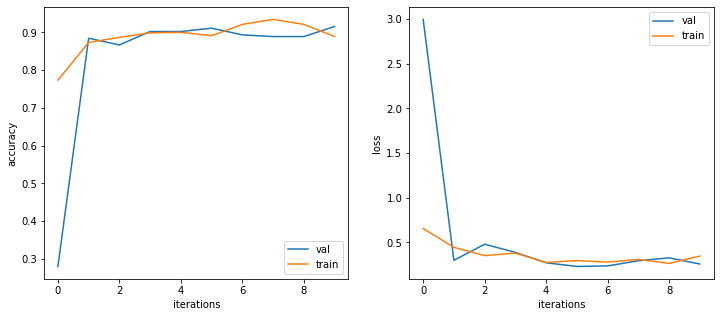

In [ ]:
plotplz()

#***K-Fold***

##Model 1

----------------- Fold 1 --------------------
Epoch 1 --- train accuracy 72.111    train losses 0.764 --- valid accuracy 54.222   valid losses 1.137
Epoch 2 --- train accuracy 86.222    train losses 0.416 --- valid accuracy 89.778   valid losses 0.258
Epoch 3 --- train accuracy 92.111    train losses 0.220 --- valid accuracy 87.111   valid losses 0.942
Epoch 4 --- train accuracy 94.333    train losses 0.160 --- valid accuracy 87.556   valid losses 0.392
Epoch 5 --- train accuracy 94.333    train losses 0.140 --- valid accuracy 87.111   valid losses 0.298
Epoch 6 --- train accuracy 95.556    train losses 0.203 --- valid accuracy 91.111   valid losses 0.287
Epoch 7 --- train accuracy 96.222    train losses 0.155 --- valid accuracy 90.222   valid losses 0.274
Epoch 8 --- train accuracy 94.778    train losses 0.168 --- valid accuracy 92.444   valid losses 0.285
Epoch 9 --- train accuracy 96.444    train losses 0.121 --- valid accuracy 87.111   valid losses 0.320
Epoch 10 --- train accuracy

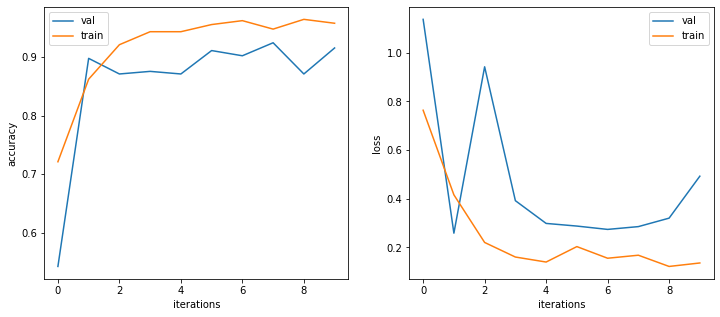

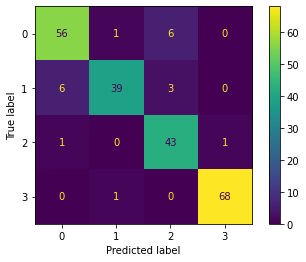

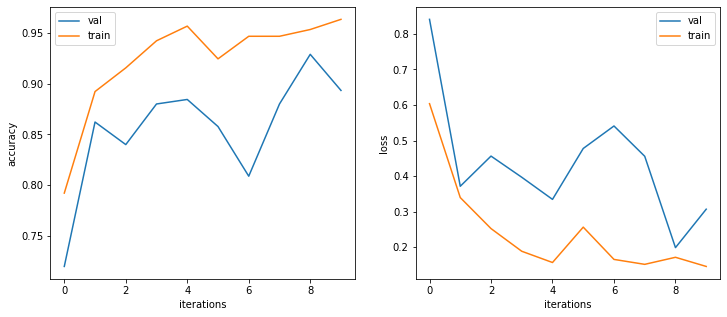

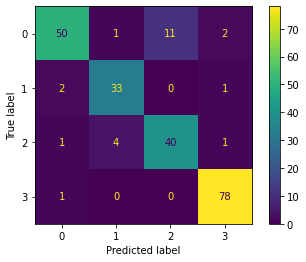

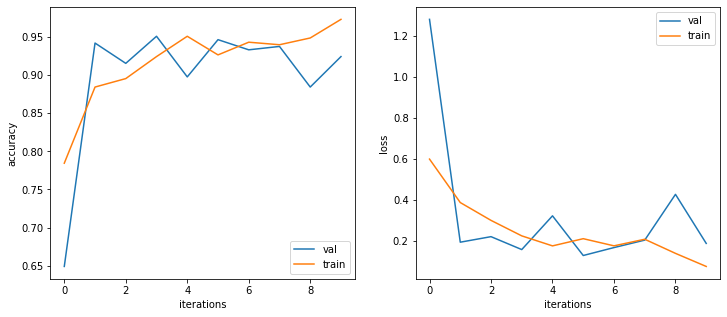

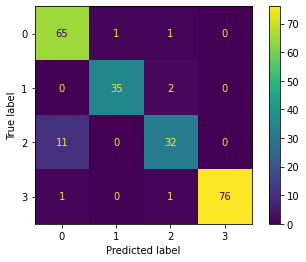

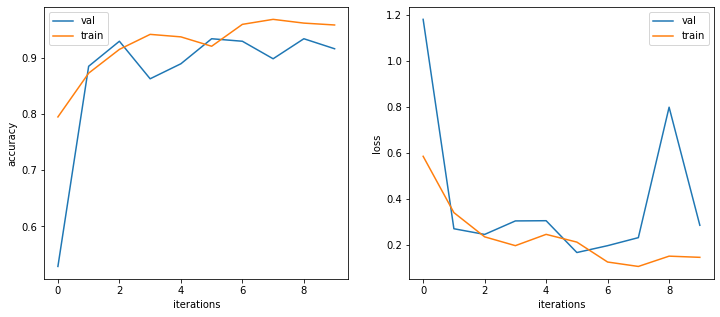

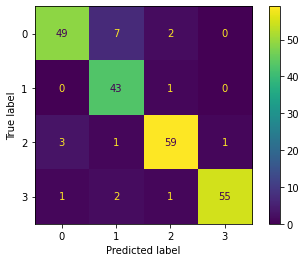

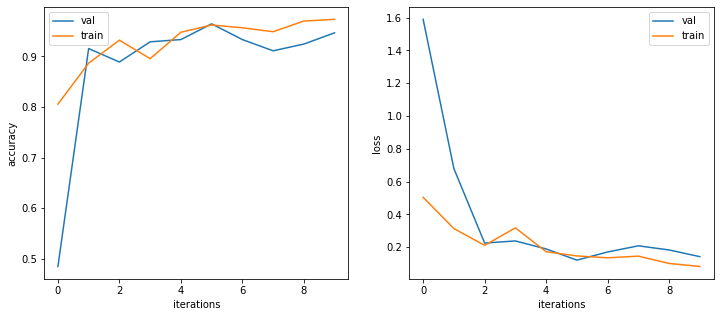

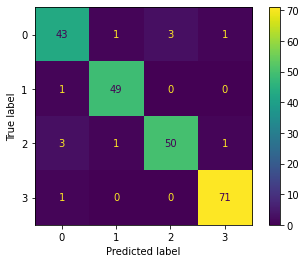

In [ ]:
BATCH_SIZE = 32

dataset = trainloader.dataset
criterion = nn.CrossEntropyLoss().to(device)

foldperf={}

kfold = KFold(n_splits=5, shuffle=True)
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f"----------------- Fold {fold+1} --------------------")
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=BATCH_SIZE, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=BATCH_SIZE, sampler=test_subsampler)

    model = ResNet18(3, ResBlock, outputs=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 10)

    plotplz()
    show_metrics(model, testloader) 
    foldperf['fold{}'.format(fold+1)] = [sum(losses_valid)/len(losses_valid),
                                        sum(losses_train)/len(losses_train),
                                        sum(acc_valid)/len(acc_valid),
                                        sum(acc_train)/len(acc_train),
                                        globprec, globrec, globf1]

    print("--------------------------------------------")

In [ ]:
cv_losses_valid, cv_losses_train, cv_acc_valid, cv_acc_train = 0, 0, 0, 0
cv_precision, cv_recall, cv_f1score = 0, 0, 0
for i in range(1, 6):
  cv_losses_valid += foldperf[f"fold{i}"][0]
  cv_losses_train += foldperf[f"fold{i}"][1]
  cv_acc_valid += foldperf[f"fold{i}"][2]
  cv_acc_train += foldperf[f"fold{i}"][3]
  cv_precision += foldperf[f"fold{i}"][4]
  cv_recall += foldperf[f"fold{i}"][5]
  cv_f1score += foldperf[f"fold{i}"][6]

print("loss train:", cv_losses_train/5, "accuracy train:", cv_acc_train/5, "loss valid:", cv_losses_valid/5, "accuracy valid", cv_acc_valid/5)
print("precision:", cv_precision/5, "recall:", cv_recall/5, "f1 score:", cv_f1score/5)

loss train: 0.23765972062945365 accuracy train: 0.9217555555555557 loss valid: 0.40172383475468454 accuracy valid 0.8730666666666667
precision: [0.89586646 0.91279357 0.87600597 0.97829447] recall: [0.87618981 0.92647707 0.88005455 0.9731045 ] f1 score: [0.8835681  0.91681909 0.87530531 0.97545928]


##Model 2

----------------- Fold 1 --------------------
Epoch 1 --- train accuracy 77.222    train losses 0.639 --- valid accuracy 29.778   valid losses 2.926
Epoch 2 --- train accuracy 89.778    train losses 0.327 --- valid accuracy 90.667   valid losses 0.241
Epoch 3 --- train accuracy 89.889    train losses 0.349 --- valid accuracy 86.222   valid losses 0.359
Epoch 4 --- train accuracy 90.556    train losses 0.300 --- valid accuracy 92.000   valid losses 0.192
Epoch 5 --- train accuracy 91.667    train losses 0.287 --- valid accuracy 91.556   valid losses 0.226
Epoch 6 --- train accuracy 93.444    train losses 0.244 --- valid accuracy 91.556   valid losses 0.264
Epoch 7 --- train accuracy 94.000    train losses 0.195 --- valid accuracy 95.556   valid losses 0.116
Epoch 8 --- train accuracy 93.444    train losses 0.216 --- valid accuracy 92.444   valid losses 0.197
Epoch 9 --- train accuracy 92.778    train losses 0.224 --- valid accuracy 92.889   valid losses 0.180
Epoch 10 --- train accuracy

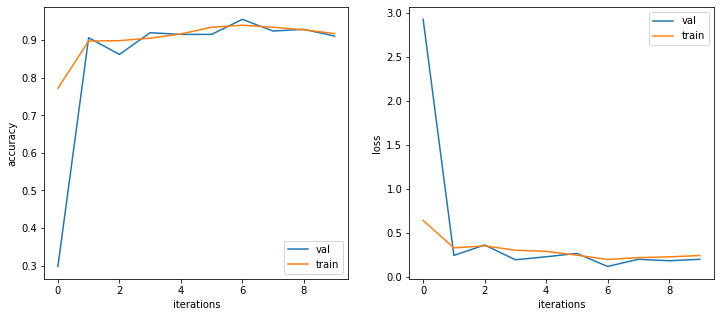

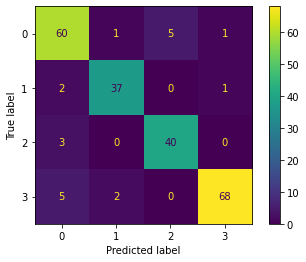

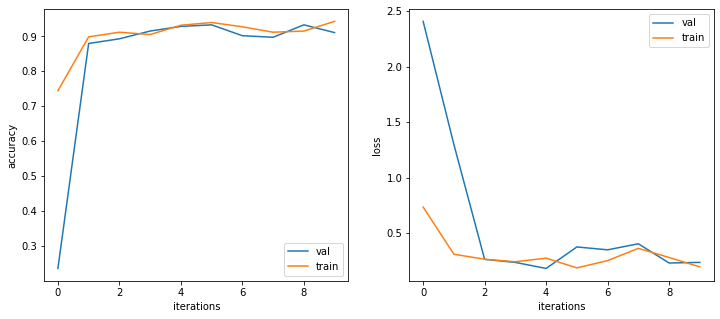

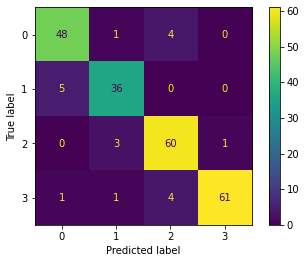

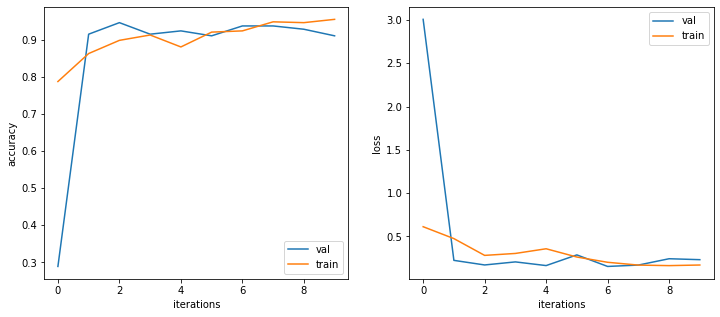

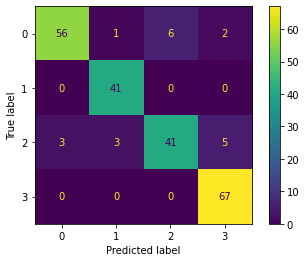

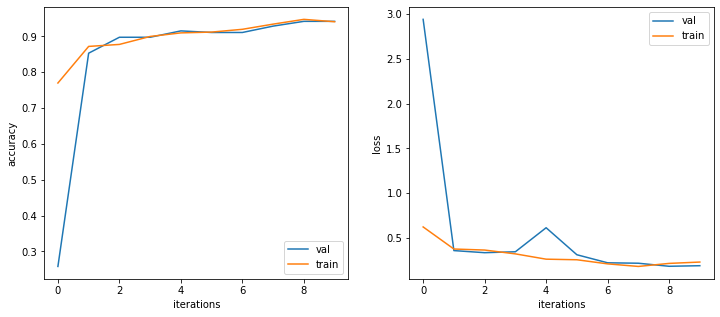

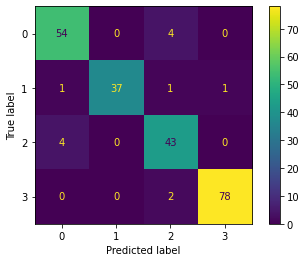

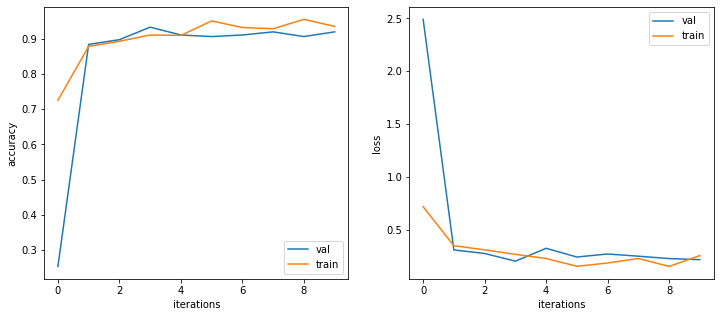

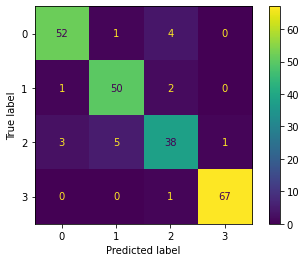

In [ ]:
BATCH_SIZE = 32

dataset = trainloader.dataset
criterion = nn.CrossEntropyLoss().to(device)

foldperf={}

kfold = KFold(n_splits=5, shuffle=True)
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f"----------------- Fold {fold+1} --------------------")
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=BATCH_SIZE, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=BATCH_SIZE, sampler=test_subsampler)

    model = Inception3(outputs=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 10)

    plotplz()
    show_metrics(model, testloader) 
    foldperf['fold{}'.format(fold+1)] = [sum(losses_valid)/len(losses_valid),
                                        sum(losses_train)/len(losses_train),
                                        sum(acc_valid)/len(acc_valid),
                                        sum(acc_train)/len(acc_train),
                                        globprec, globrec, globf1]

    print("--------------------------------------------")

In [ ]:
cv_losses_valid, cv_losses_train, cv_acc_valid, cv_acc_train = 0, 0, 0, 0
cv_precision, cv_recall, cv_f1score = 0, 0, 0
for i in range(1, 6):
  cv_losses_valid += foldperf[f"fold{i}"][0]
  cv_losses_train += foldperf[f"fold{i}"][1]
  cv_acc_valid += foldperf[f"fold{i}"][2]
  cv_acc_train += foldperf[f"fold{i}"][3]
  cv_precision += foldperf[f"fold{i}"][4]
  cv_recall += foldperf[f"fold{i}"][5]
  cv_f1score += foldperf[f"fold{i}"][6]

print("loss train:", cv_losses_train/5, "accuracy train:", cv_acc_train/5, "loss valid:", cv_losses_valid/5, "accuracy valid", cv_acc_valid/5)
print("precision:", cv_precision/5, "recall:", cv_recall/5, "f1 score:", cv_f1score/5)

loss train: 0.2999678068123115 accuracy train: 0.9025333333333334 loss valid: 0.5250066599568846 accuracy valid 0.8497777777777777
precision: [0.90780199 0.92140341 0.86960534 0.96666817] recall: [0.90120728 0.934289   0.87591967 0.95548171] f1 score: [0.90395308 0.92700146 0.87182991 0.96008965]


##Model 3

----------------- Fold 1 --------------------
Epoch 1 --- train accuracy 86.222    train losses 0.423 --- valid accuracy 96.444   valid losses 0.095
Epoch 2 --- train accuracy 95.889    train losses 0.113 --- valid accuracy 98.222   valid losses 0.042
Epoch 3 --- train accuracy 97.333    train losses 0.073 --- valid accuracy 97.333   valid losses 0.050
Epoch 4 --- train accuracy 98.000    train losses 0.065 --- valid accuracy 97.778   valid losses 0.060
Epoch 5 --- train accuracy 96.778    train losses 0.092 --- valid accuracy 96.889   valid losses 0.087
Epoch 6 --- train accuracy 97.000    train losses 0.074 --- valid accuracy 97.778   valid losses 0.066
Epoch 7 --- train accuracy 98.556    train losses 0.048 --- valid accuracy 96.889   valid losses 0.060
Epoch 8 --- train accuracy 97.556    train losses 0.079 --- valid accuracy 97.333   valid losses 0.049
Epoch 9 --- train accuracy 98.667    train losses 0.041 --- valid accuracy 99.111   valid losses 0.049
Epoch 10 --- train accuracy

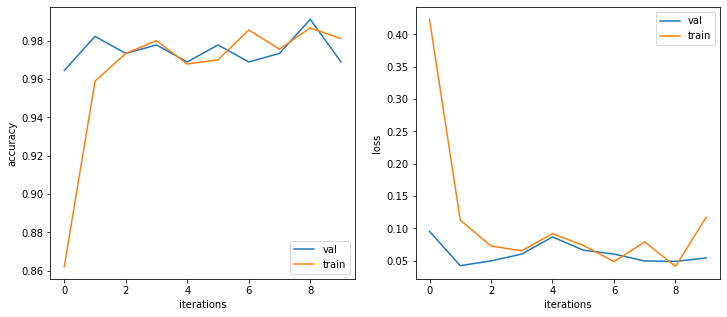

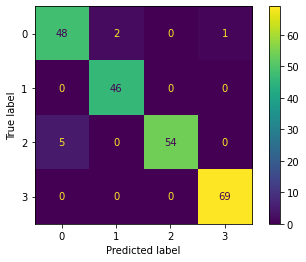

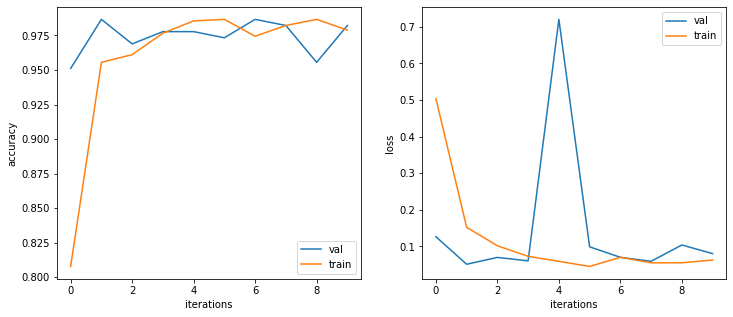

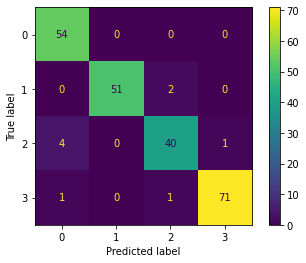

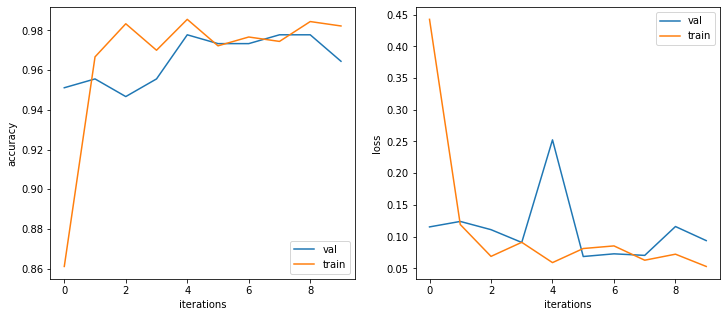

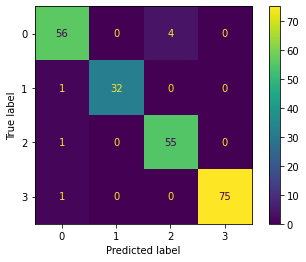

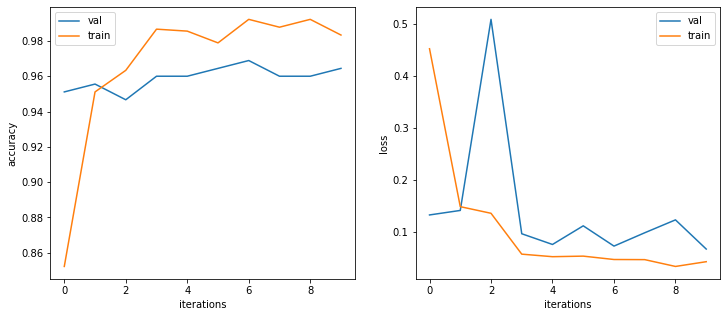

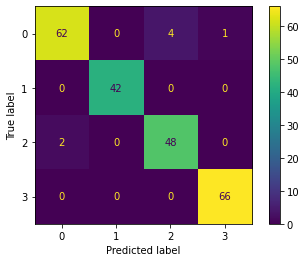

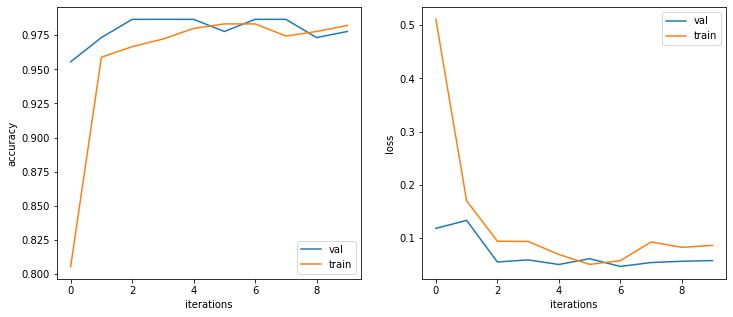

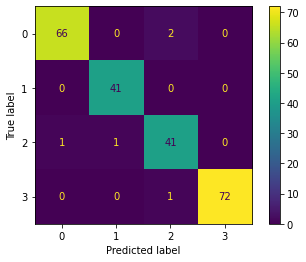

In [ ]:
BATCH_SIZE = 32

dataset = trainloader.dataset
criterion = nn.CrossEntropyLoss().to(device)

foldperf={}

kfold = KFold(n_splits=5, shuffle=True)
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f"----------------- Fold {fold+1} --------------------")
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=BATCH_SIZE, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=BATCH_SIZE, sampler=test_subsampler)

    model = resnet18(progress=False, pretrained=True).to(device)
    model.fc = nn.Linear(512, 4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 10)

    plotplz()
    show_metrics(model, testloader) 
    foldperf['fold{}'.format(fold+1)] = [sum(losses_valid)/len(losses_valid),
                                        sum(losses_train)/len(losses_train),
                                        sum(acc_valid)/len(acc_valid),
                                        sum(acc_train)/len(acc_train),
                                        globprec, globrec, globf1]

    print("--------------------------------------------")

In [ ]:
cv_losses_valid, cv_losses_train, cv_acc_valid, cv_acc_train = 0, 0, 0, 0
cv_precision, cv_recall, cv_f1score = 0, 0, 0
for i in range(1, 6):
  cv_losses_valid += foldperf[f"fold{i}"][0]
  cv_losses_train += foldperf[f"fold{i}"][1]
  cv_acc_valid += foldperf[f"fold{i}"][2]
  cv_acc_train += foldperf[f"fold{i}"][3]
  cv_precision += foldperf[f"fold{i}"][4]
  cv_recall += foldperf[f"fold{i}"][5]
  cv_f1score += foldperf[f"fold{i}"][6]

print("loss train:", cv_losses_train/5, "accuracy train:", cv_acc_train/5, "loss valid:", cv_losses_valid/5, "accuracy valid", cv_acc_valid/5)
print("precision:", cv_precision/5, "recall:", cv_recall/5, "f1 score:", cv_f1score/5)

loss train: 0.11636022580006751 accuracy train: 0.9630222222222222 loss valid: 0.10580715625224338 accuracy valid 0.9704888888888888
precision: [0.94477836 0.98690476 0.94346621 0.99138   ] recall: [0.95409423 0.98639222 0.93995487 0.98914924] f1 score: [0.94886965 0.98641197 0.94101401 0.99021565]


#***Transfer Learning***

## Without freezing the layers

### Training

In [ ]:
from torchvision.models import resnet18

model = resnet18(progress=False, pretrained=True).to(device)
model.fc = nn.Linear(512, 4).to(device)


In [ ]:
summary(model, (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           9,408
       BatchNorm2d-2         [-1, 64, 125, 125]             128
              ReLU-3         [-1, 64, 125, 125]               0
         MaxPool2d-4           [-1, 64, 63, 63]               0
            Conv2d-5           [-1, 64, 63, 63]          36,864
       BatchNorm2d-6           [-1, 64, 63, 63]             128
              ReLU-7           [-1, 64, 63, 63]               0
            Conv2d-8           [-1, 64, 63, 63]          36,864
       BatchNorm2d-9           [-1, 64, 63, 63]             128
             ReLU-10           [-1, 64, 63, 63]               0
       BasicBlock-11           [-1, 64, 63, 63]               0
           Conv2d-12           [-1, 64, 63, 63]          36,864
      BatchNorm2d-13           [-1, 64, 63, 63]             128
             ReLU-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 20)

Epoch 1 --- train accuracy 86.889    train losses 0.402 --- valid accuracy 97.778   valid losses 0.067
Epoch 2 --- train accuracy 99.111    train losses 0.044 --- valid accuracy 97.778   valid losses 0.045
Epoch 3 --- train accuracy 100.000    train losses 0.017 --- valid accuracy 98.667   valid losses 0.034
Epoch 4 --- train accuracy 99.889    train losses 0.022 --- valid accuracy 97.778   valid losses 0.052
Epoch 5 --- train accuracy 99.556    train losses 0.036 --- valid accuracy 97.778   valid losses 0.047
Epoch 6 --- train accuracy 99.667    train losses 0.021 --- valid accuracy 96.889   valid losses 0.055
Epoch 7 --- train accuracy 99.889    train losses 0.013 --- valid accuracy 99.556   valid losses 0.045
Epoch 8 --- train accuracy 99.667    train losses 0.023 --- valid accuracy 97.333   valid losses 0.052
Epoch 9 --- train accuracy 99.778    train losses 0.013 --- valid accuracy 98.222   valid losses 0.050
Epoch 10 --- train accuracy 99.889    train losses 0.010 --- valid accur

### Train data metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       246
           1       1.00      1.00      1.00       166
           2       0.99      1.00      1.00       198
           3       1.00      1.00      1.00       290

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



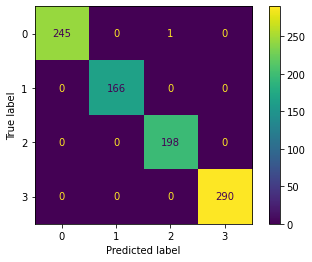

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        54
           1       1.00      1.00      1.00        49
           2       0.90      1.00      0.95        55
           3       1.00      0.99      0.99        67

    accuracy                           0.97       225
   macro avg       0.98      0.97      0.97       225
weighted avg       0.98      0.97      0.97       225



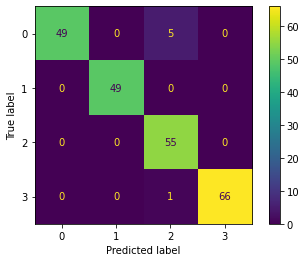

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

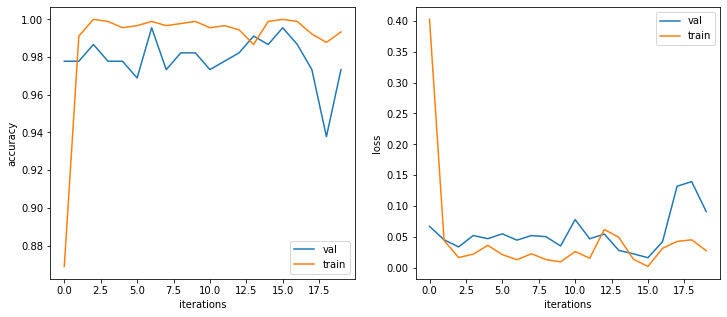

In [ ]:
plotplz()

## Freezed layers

### Training

In [ ]:
from torchvision.models import resnet18

model = resnet18(progress=False, pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(512, 256),
                         nn.Dropout(0.2),
                         nn.Linear(256, 4)).to(device)

In [ ]:
summary(model, (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           9,408
       BatchNorm2d-2         [-1, 64, 125, 125]             128
              ReLU-3         [-1, 64, 125, 125]               0
         MaxPool2d-4           [-1, 64, 63, 63]               0
            Conv2d-5           [-1, 64, 63, 63]          36,864
       BatchNorm2d-6           [-1, 64, 63, 63]             128
              ReLU-7           [-1, 64, 63, 63]               0
            Conv2d-8           [-1, 64, 63, 63]          36,864
       BatchNorm2d-9           [-1, 64, 63, 63]             128
             ReLU-10           [-1, 64, 63, 63]               0
       BasicBlock-11           [-1, 64, 63, 63]               0
           Conv2d-12           [-1, 64, 63, 63]          36,864
      BatchNorm2d-13           [-1, 64, 63, 63]             128
             ReLU-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, criterion, optimizer, 40)

Epoch 1 --- train accuracy 50.000    train losses 1.193 --- valid accuracy 80.444   valid losses 0.887
Epoch 2 --- train accuracy 78.778    train losses 0.838 --- valid accuracy 86.222   valid losses 0.648
Epoch 3 --- train accuracy 85.778    train losses 0.656 --- valid accuracy 94.222   valid losses 0.504
Epoch 4 --- train accuracy 89.556    train losses 0.528 --- valid accuracy 93.778   valid losses 0.379
Epoch 5 --- train accuracy 91.778    train losses 0.441 --- valid accuracy 92.889   valid losses 0.426
Epoch 6 --- train accuracy 92.889    train losses 0.366 --- valid accuracy 95.111   valid losses 0.296
Epoch 7 --- train accuracy 94.556    train losses 0.367 --- valid accuracy 95.111   valid losses 0.298
Epoch 8 --- train accuracy 93.778    train losses 0.310 --- valid accuracy 95.111   valid losses 0.230
Epoch 9 --- train accuracy 95.222    train losses 0.265 --- valid accuracy 95.111   valid losses 0.217
Epoch 10 --- train accuracy 95.667    train losses 0.237 --- valid accura

### Train data metrics

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       246
           1       1.00      1.00      1.00       166
           2       0.97      0.98      0.98       198
           3       0.99      1.00      1.00       290

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



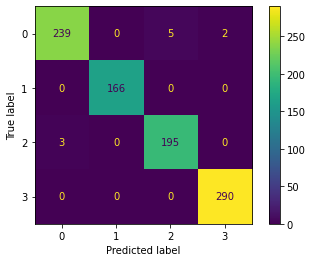

In [ ]:
show_metrics(model, trainloader)

### Test data metrics

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        54
           1       0.96      0.98      0.97        49
           2       0.91      0.89      0.90        55
           3       0.99      0.99      0.99        67

    accuracy                           0.95       225
   macro avg       0.95      0.95      0.95       225
weighted avg       0.95      0.95      0.95       225



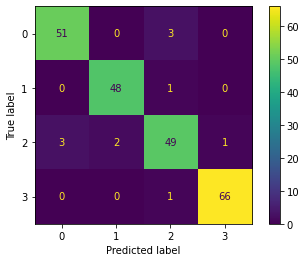

In [ ]:
show_metrics(model, testloader)

### Loss/Accuracy plots

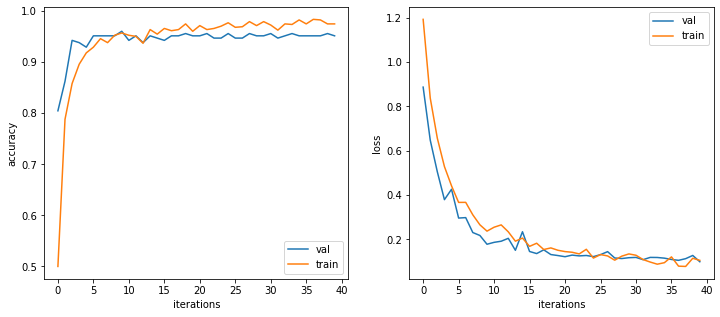

In [ ]:
plotplz()